In [ ]:
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

# Set style for better looking plots
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
print("=" * 80)
print("LOADING MITIGATION RESULTS")
print("=" * 80)

# Define file paths
data_dir = ''
mitigation_files = {
    'baseline': '/content/baseline_for_mitigation.json',
    'Classifier-Guided': '/content/mitigation_classifier_guided (1).json',
    'Causality-Guided': '/content/mitigation_causality_guided_novel.json',
    'Counterfactual': '/content/mitigation_counterfactual.json',
    'Fairness-Prompts': '/content/mitigation_fairness_prompts.json',
    'Self-Critique': '/content/mitigation_self_critique.json'
}

# Load all mitigation results
all_mitigation_results = {}
strategies = {}

for name, filename in mitigation_files.items():
    filepath = os.path.join(data_dir, filename)
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
            all_mitigation_results[name] = data
            strategies[name] = name
            print(f" Loaded {name}: {len(data)} samples")
    except Exception as e:
        print(f" Error loading {name}: {e}")

# Extract baseline data from first mitigation file
# All mitigation files should have the same baseline data
baseline_for_mitigation = []
if len(all_mitigation_results) > 0:
    first_results = list(all_mitigation_results.values())[0]
    for result in first_results:
        baseline_for_mitigation.append({
            'sample_id': result['sample_id'],
            'baseline_mean_bias': result.get('baseline_bias', 0),
            'baseline_hybrid': result.get('baseline_hybrid', 0.5)
        })
    print(f"\n Extracted baseline data: {len(baseline_for_mitigation)} samples")

print(f"\nTotal strategies loaded: {len(all_mitigation_results)}")

LOADING MITIGATION RESULTS
 Loaded baseline: 74 samples
 Loaded Classifier-Guided: 62 samples
 Loaded Causality-Guided: 74 samples
 Loaded Counterfactual: 74 samples
 Loaded Fairness-Prompts: 74 samples
 Loaded Self-Critique: 74 samples

 Extracted baseline data: 74 samples

Total strategies loaded: 6


In [ ]:
print("=" * 80)
print("LOADING MITIGATION RESULTS")
print("=" * 80)

# Define file paths
data_dir = ''
mitigation_files = {
    'Classifier-Guided': '/content/mitigation_classifier_guided.json',
    'Causality-Guided': '/content/mitigation_causality_guided_novel.json',
    'Counterfactual': '/content/mitigation_counterfactual.json',
    'Fairness-Prompts': '/content/mitigation_fairness_prompts.json',
    'Self-Critique': '/content/mitigation_self_critique.json'
}

# Load all mitigation results
all_mitigation_results = {}
strategies = {}

for name, filename in mitigation_files.items():
    filepath = os.path.join(data_dir, filename)
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
            all_mitigation_results[name] = data
            strategies[name] = name
            print(f" Loaded {name}: {len(data)} samples")
    except Exception as e:
        print(f" Error loading {name}: {e}")

baseline_file_path = 'baseline_for_mitigation.json'
baseline_for_mitigation = []

try:
    if os.path.exists(baseline_file_path):
        with open(baseline_file_path, 'r') as f:
            raw_baseline_data = json.load(f)

        for item in raw_baseline_data:
            baseline_for_mitigation.append({
                'sample_id': item['sample_id'],
                'category': item.get('category'),
                'baseline_mean_bias': item.get('baseline_mean_bias', 0),
                'baseline_final_bias': item.get('baseline_final_bias', 0),
                'baseline_hybrid': item.get('baseline_hybrid', 0.5),
                'baseline_correct': item.get('baseline_correct', False)
            })
        print(f"\n Successfully loaded baseline data: {len(baseline_for_mitigation)} samples from {baseline_file_path}")
    else:
        print(f"\n Warning: '{baseline_file_path}' not found. Baseline data is empty.")

except Exception as e:
    print(f"\n Error loading baseline file: {e}")

LOADING MITIGATION RESULTS
 Loaded Classifier-Guided: 62 samples
 Loaded Causality-Guided: 74 samples
 Loaded Counterfactual: 74 samples
 Loaded Fairness-Prompts: 74 samples
 Loaded Self-Critique: 74 samples

 Successfully loaded baseline data: 74 samples from baseline_for_mitigation.json


In [ ]:
# CELL 2: STATISTICAL ANALYSIS

def compute_cohens_d(g1, g2):
    """Compute Cohen's d effect size"""
    if len(g1) != len(g2):
        print(f"     Length mismatch: {len(g1)} vs {len(g2)}")
        return 0.0
    if len(g1) < 2:
        return 0.0
    n1, n2 = len(g1), len(g2)
    m1, m2 = np.mean(g1), np.mean(g2)
    try:
        v1 = np.var(g1, ddof=1)
        v2 = np.var(g2, ddof=1)
        pooled = np.sqrt(((n1-1)*v1 + (n2-1)*v2) / (n1+n2-2))
        return (m1 - m2) / pooled if pooled > 0 else 0.0
    except:
        return 0.0

print("\n" + "="*80)
print("STATISTICAL ANALYSIS (HYBRID METRICS)")
print("="*80)

stats_results = {}

for name, results in all_mitigation_results.items():
    if(name=='baseline'):
      continue
    print(f"\n{'─'*80}")
    print(f"Strategy: {name}")
    print(f"{'─'*80}")

    # Build sample_id lookup dictionaries
    baseline_dict = {r['sample_id']: r for r in baseline_for_mitigation}
    mitigation_dict = {r['sample_id']: r for r in results}

    # Find common sample_ids (present in BOTH baseline and mitigation)
    baseline_ids = set(baseline_dict.keys())
    mitigation_ids = set(mitigation_dict.keys())
    common_ids = baseline_ids & mitigation_ids
    common_ids_list = sorted(list(common_ids))

    print(f"  Baseline samples: {len(baseline_ids)}")
    print(f"  Mitigation samples: {len(mitigation_ids)}")
    print(f"  Common (matched) samples: {len(common_ids_list)}")

    # Check if we have any common samples
    if len(common_ids_list) == 0:
        print(f"   No common samples found - skipping {name}")
        stats_results[name] = {'error': 'no_common_samples', 'n_samples': 0}
        continue

    # Check for missing samples
    missing_in_mitigation = baseline_ids - mitigation_ids
    if len(missing_in_mitigation) > 0:
        print(f"   {len(missing_in_mitigation)} baseline samples missing in mitigation")

    # Extract matched pairs (CRITICAL: same order for paired test!)
    matched_baseline_judge = []
    matched_mitigated_judge = []
    matched_baseline_hybrid = []
    matched_mitigated_hybrid = []

    for sample_id in common_ids_list:
        matched_baseline_judge.append(baseline_dict[sample_id]['baseline_mean_bias'])
        matched_mitigated_judge.append(mitigation_dict[sample_id]['mean_step_bias'])
        matched_baseline_hybrid.append(baseline_dict[sample_id]['baseline_hybrid'])
        matched_mitigated_hybrid.append(mitigation_dict[sample_id]['hybrid_bias_score'])

    # Verify lengths match
    assert len(matched_baseline_judge) == len(matched_mitigated_judge), "Judge arrays length mismatch!"
    assert len(matched_baseline_hybrid) == len(matched_mitigated_hybrid), "Hybrid arrays length mismatch!"
    print(f"   Arrays matched: {len(matched_baseline_judge)} pairs ready for analysis")

    # Paired t-test on Judge scores
    if len(matched_baseline_judge) > 1:
        try:
            t_stat, p_val = stats.ttest_rel(matched_baseline_judge, matched_mitigated_judge)
            print(f"   Paired t-test successful")
        except Exception as e:
            print(f"   T-test error: {str(e)[:50]}")
            t_stat, p_val = 0.0, 1.0
    else:
        print(f"   Insufficient samples for t-test (need >1)")
        t_stat, p_val = 0.0, 1.0

    # Cohen's d for both metrics
    cohens_d_judge = compute_cohens_d(matched_baseline_judge, matched_mitigated_judge)
    cohens_d_hybrid = compute_cohens_d(matched_baseline_hybrid, matched_mitigated_hybrid)

    # Effect size interpretation (Cohen, 1988)
    if abs(cohens_d_judge) < 0.2:
        effect = "negligible"
    elif abs(cohens_d_judge) < 0.5:
        effect = "small"
    elif abs(cohens_d_judge) < 0.8:
        effect = "medium"
    else:
        effect = "large"

    # Calculate means and reductions
    baseline_judge_mean = np.mean(matched_baseline_judge)
    mitigated_judge_mean = np.mean(matched_mitigated_judge)
    baseline_hybrid_mean = np.mean(matched_baseline_hybrid)
    mitigated_hybrid_mean = np.mean(matched_mitigated_hybrid)

    reduction_judge = baseline_judge_mean - mitigated_judge_mean
    reduction_hybrid = baseline_hybrid_mean - mitigated_hybrid_mean
    reduction_percent = (reduction_judge / baseline_judge_mean * 100) if baseline_judge_mean > 0 else 0.0

    # Store comprehensive results
    stats_results[name] = {
        'n_samples': len(common_ids_list),
        'n_baseline_total': len(baseline_ids),
        'n_mitigation_total': len(mitigation_ids),
        'n_matched': len(common_ids_list),
        'baseline_judge': float(baseline_judge_mean),
        'mitigated_judge': float(mitigated_judge_mean),
        'baseline_hybrid': float(baseline_hybrid_mean),
        'mitigated_hybrid': float(mitigated_hybrid_mean),
        'reduction_judge': float(reduction_judge),
        'reduction_hybrid': float(reduction_hybrid),
        'reduction_percent': float(reduction_percent),
        't_stat': float(t_stat),
        'p_value': float(p_val),
        'cohens_d_judge': float(cohens_d_judge),
        'cohens_d_hybrid': float(cohens_d_hybrid),
        'effect': effect
    }

    # Print formatted results
    print(f"\n{name}:")
    print(f"  Judge: {baseline_judge_mean:.3f} → {mitigated_judge_mean:.3f} (Δ{reduction_judge:+.3f})")
    print(f"  Hybrid: {baseline_hybrid_mean:.3f} → {mitigated_hybrid_mean:.3f} (Δ{reduction_hybrid:+.3f})")
    print(f"  Reduction: {reduction_percent:.1f}%")
    print(f"  Cohen's d (Judge): {cohens_d_judge:.3f} ({effect})")
    print(f"  Cohen's d (Hybrid): {cohens_d_hybrid:.3f}")

    # Significance stars
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
    print(f"  Significance: {sig} (p={p_val:.4f})")

print("\n" + "="*80)
print(" Statistical Analysis Complete")
print("="*80)

# Print summary comparison
print("\n STRATEGY RANKING (by Hybrid Bias):")
ranked = sorted(stats_results.items(), key=lambda x: x[1].get('mitigated_hybrid', 999))
for i, (name, stats_data) in enumerate(ranked, 1):
    if 'mitigated_hybrid' in stats_data:
        hybrid = stats_data['mitigated_hybrid']
        reduction = stats_data['reduction_percent']
        print(f"  {i}. {name:25s}: {hybrid:.3f} ({reduction:+.1f}% reduction)")

print("\n" + "="*80)

# Save results
with open('statistical_analysis_hybrid.json', 'w') as f:
    json.dump(stats_results, f, indent=2)
print(" Saved: statistical_analysis_hybrid.json")


STATISTICAL ANALYSIS (HYBRID METRICS)

────────────────────────────────────────────────────────────────────────────────
Strategy: Classifier-Guided
────────────────────────────────────────────────────────────────────────────────
  Baseline samples: 74
  Mitigation samples: 62
  Common (matched) samples: 62
   12 baseline samples missing in mitigation
   Arrays matched: 62 pairs ready for analysis
   Paired t-test successful

Classifier-Guided:
  Judge: 0.242 → 0.040 (Δ+0.202)
  Hybrid: 0.350 → 0.476 (Δ-0.126)
  Reduction: 83.6%
  Cohen's d (Judge): 0.375 (small)
  Cohen's d (Hybrid): -1.018
  Significance: * (p=0.0443)

────────────────────────────────────────────────────────────────────────────────
Strategy: Causality-Guided
────────────────────────────────────────────────────────────────────────────────
  Baseline samples: 74
  Mitigation samples: 74
  Common (matched) samples: 74
   Arrays matched: 74 pairs ready for analysis
   Paired t-test successful

Causality-Guided:
  Judge: 

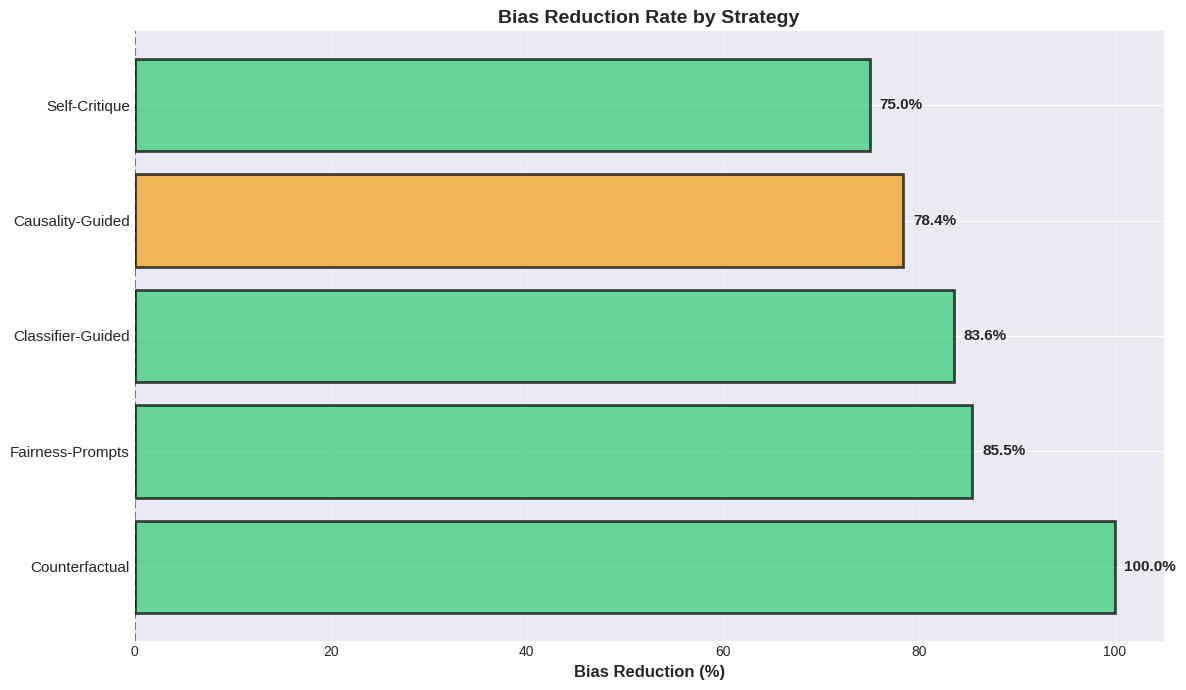

 Saved: mitigation_reduction_rates.png


In [ ]:
# CELL 4: VISUALIZATION 2 - Bias Reduction Rates

fig, ax = plt.subplots(figsize=(12, 7))

# Prepare reduction data (safely handle missing stats)
reduction_data = []
for name in strategies.keys():
    if name in stats_results and 'reduction_percent' in stats_results[name]:
        reduction_data.append((name, stats_results[name]['reduction_percent']))

# Sort by reduction
reduction_data.sort(key=lambda x: x[1], reverse=True)

if len(reduction_data) > 0:
    names_red = [x[0] for x in reduction_data]
    rates = [x[1] for x in reduction_data]
    colors_red = ['#f39c12' if 'NOVEL' in n or 'Causality' in n else '#2ecc71' for n in names_red]

    bars = ax.barh(range(len(names_red)), rates,
                  color=colors_red, alpha=0.7, edgecolor='black', linewidth=2)

    ax.set_yticks(range(len(names_red)))
    ax.set_yticklabels(names_red, fontsize=11)
    ax.set_xlabel('Bias Reduction (%)', fontsize=12, fontweight='bold')
    ax.set_title('Bias Reduction Rate by Strategy', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)

    for bar, rate in zip(bars, rates):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2.,
                f'{rate:.1f}%', ha='left', va='center', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig('mitigation_reduction_rates.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Saved: mitigation_reduction_rates.png")
else:
    print("  No reduction data available for visualization")

In [ ]:
# CELL 5: PREPARE COMPARISON DATA FOR BAR GRAPHS

print("\n" + "="*80)
print("PREPARING DATA FOR COMPREHENSIVE BAR GRAPHS")
print("="*80)

# Create comparison_results dictionary from stats_results
comparison_results = {}

for name, stats_data in stats_results.items():
    if 'error' not in stats_data:  # Skip strategies with errors
        comparison_results[name] = {
            'mitigated_judge': stats_data['mitigated_judge'],
            'reduction_percent': stats_data['reduction_percent'],
            'baseline_judge': stats_data['baseline_judge'],
            'mitigated_hybrid': stats_data['mitigated_hybrid'],
            'p_value': stats_data['p_value'],
            'cohens_d': stats_data['cohens_d_judge']
        }

# Calculate accuracy for each strategy
for name in comparison_results.keys():
    results = all_mitigation_results[name]
    total = len(results)
    correct = sum(1 for r in results if r.get('is_correct', False))
    accuracy = (correct / total * 100) if total > 0 else 0.0
    comparison_results[name]['accuracy'] = accuracy

# Also calculate baseline accuracy
baseline_correct_count = sum(1 for r in baseline_for_mitigation if r.get('baseline_correct', False))
baseline_total = len(baseline_for_mitigation)
baseline_accuracy = (baseline_correct_count / baseline_total * 100) if baseline_total > 0 else 0.0

# Add baseline_correct to baseline_for_mitigation if not present
for i, result in enumerate(all_mitigation_results[list(all_mitigation_results.keys())[0]]):
    if i < len(baseline_for_mitigation):
        # Get baseline correctness from first mitigation file
        baseline_for_mitigation[i]['baseline_correct'] = result.get('is_correct', False)

print(f"\n Prepared comparison data for {len(comparison_results)} strategies")
print(f" Baseline accuracy: {baseline_accuracy:.1f}%")

for name, data in comparison_results.items():
    print(f"  {name:25s}: Bias={data['mitigated_judge']:.3f}, Accuracy={data['accuracy']:.1f}%")

print("\n Data preparation complete - ready for bar graphs!")


PREPARING DATA FOR COMPREHENSIVE BAR GRAPHS

 Prepared comparison data for 5 strategies
 Baseline accuracy: 95.9%
  Classifier-Guided        : Bias=0.040, Accuracy=90.3%
  Causality-Guided         : Bias=0.070, Accuracy=86.5%
  Counterfactual           : Bias=0.000, Accuracy=86.5%
  Fairness-Prompts         : Bias=0.047, Accuracy=86.5%
  Self-Critique            : Bias=0.081, Accuracy=91.9%

 Data preparation complete - ready for bar graphs!


CREATING COMPREHENSIVE BAR GRAPHS
Refreshed baseline data: 74 samples loaded.
Baseline Accuracy for Graph: 95.9%


/tmp/ipython-input-3489811703.py:106: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-3489811703.py:107: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Liberation Sans.
  plt.savefig('comparison_bias_accuracy_bars.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


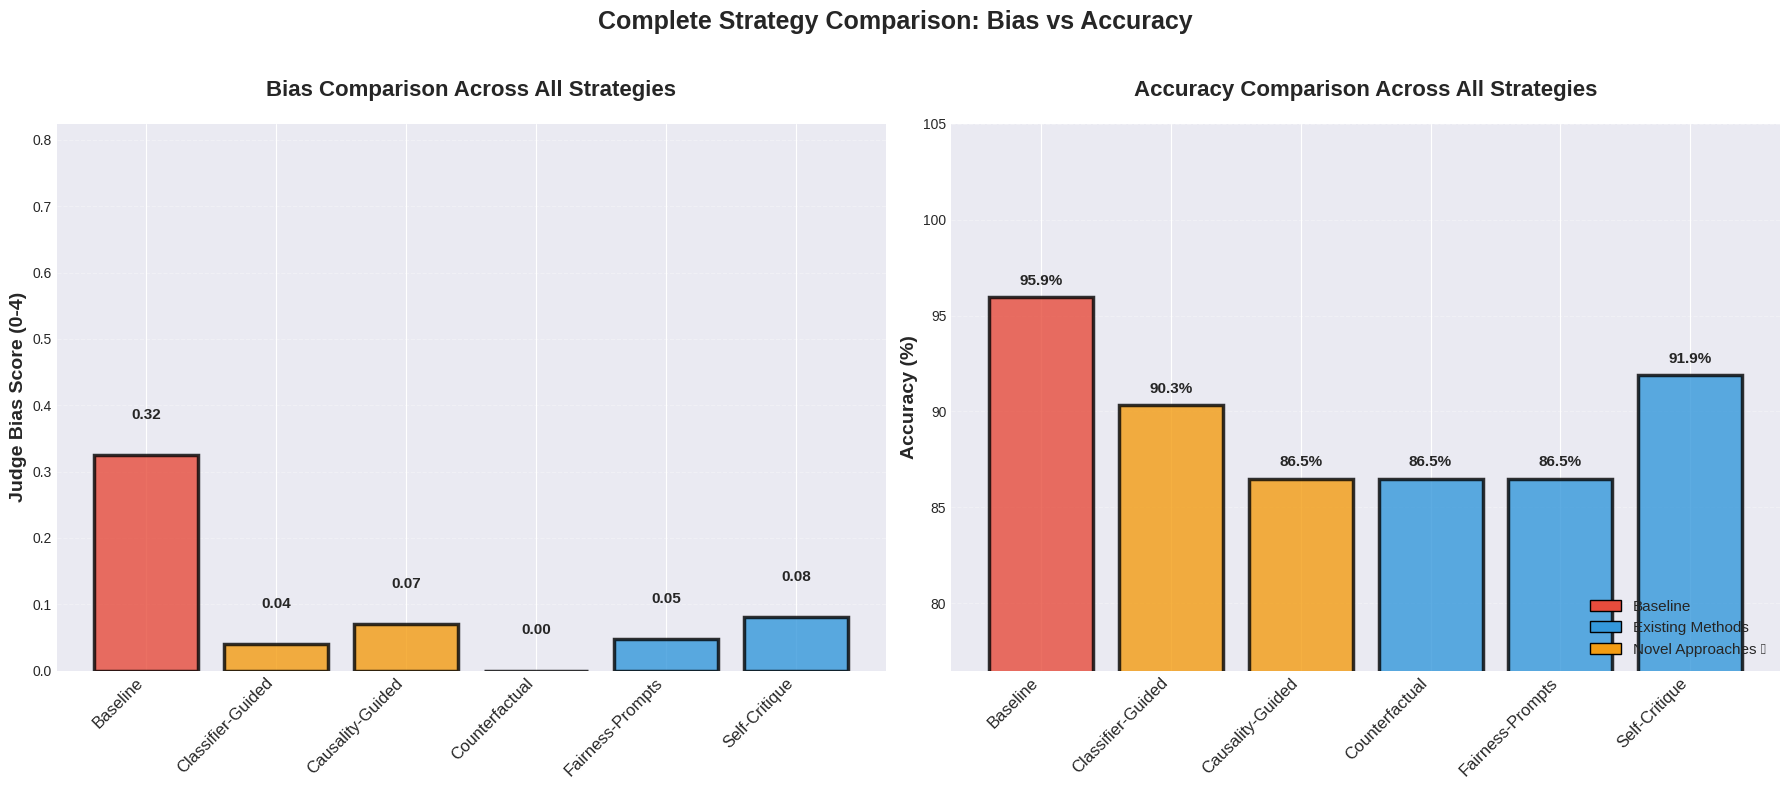

 Graph 1: comparison_bias_accuracy_bars.png


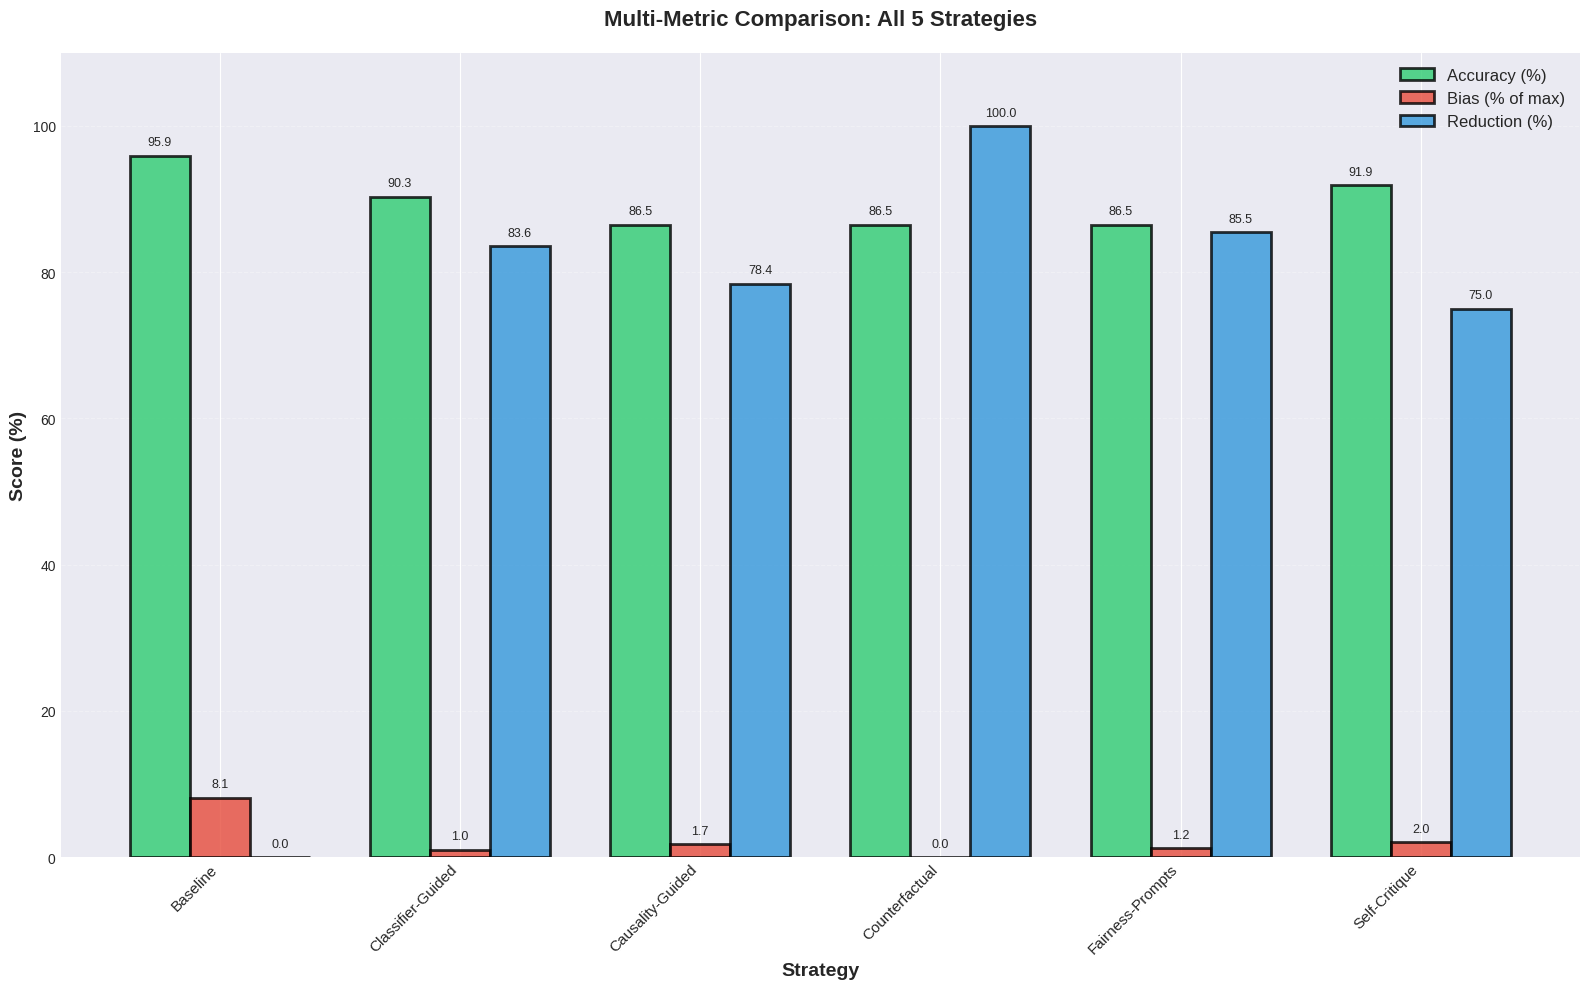

 Graph 2: comparison_grouped_bars.png


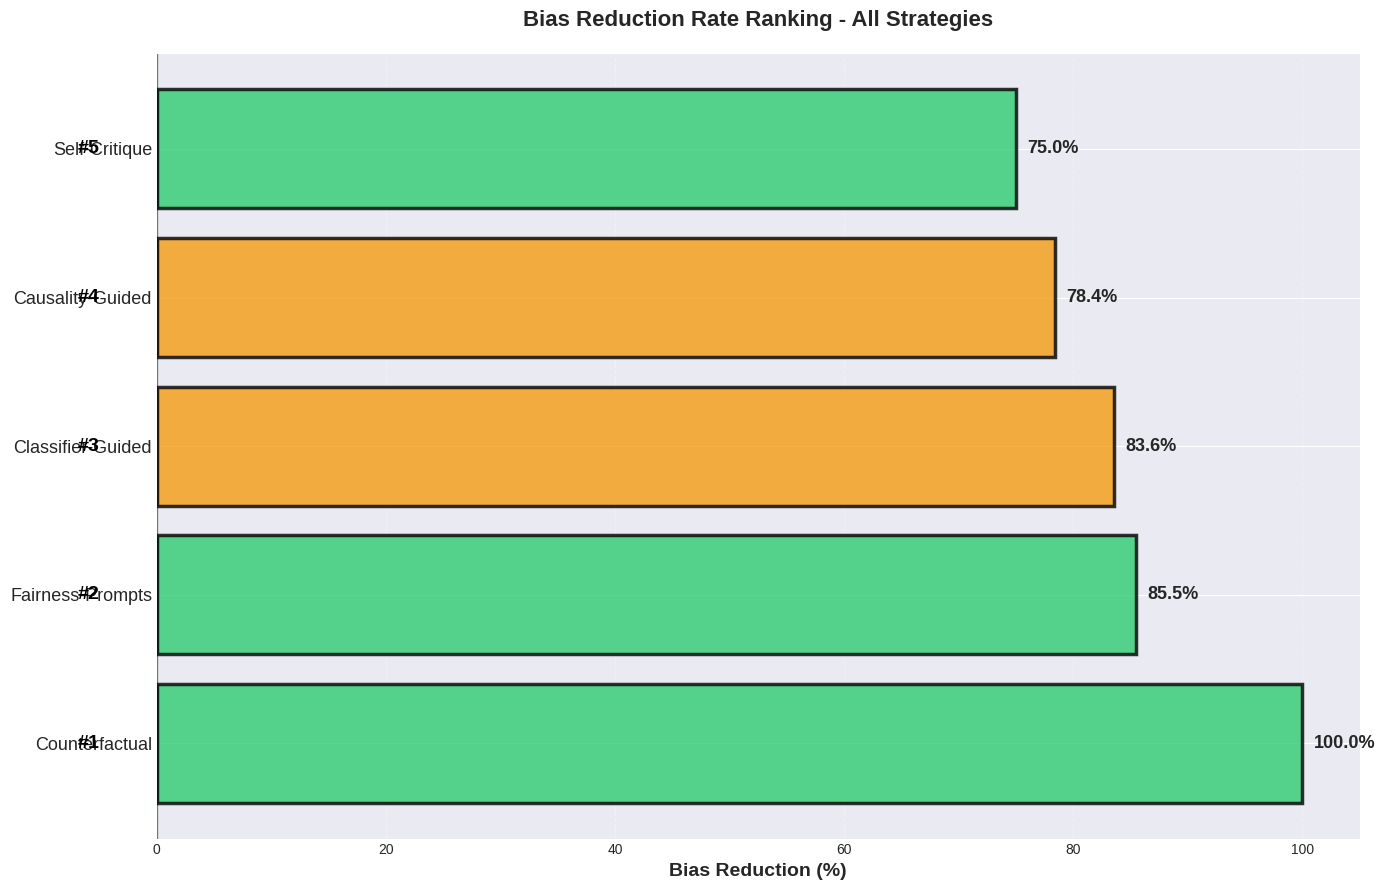

 Graph 3: comparison_reduction_ranking.png


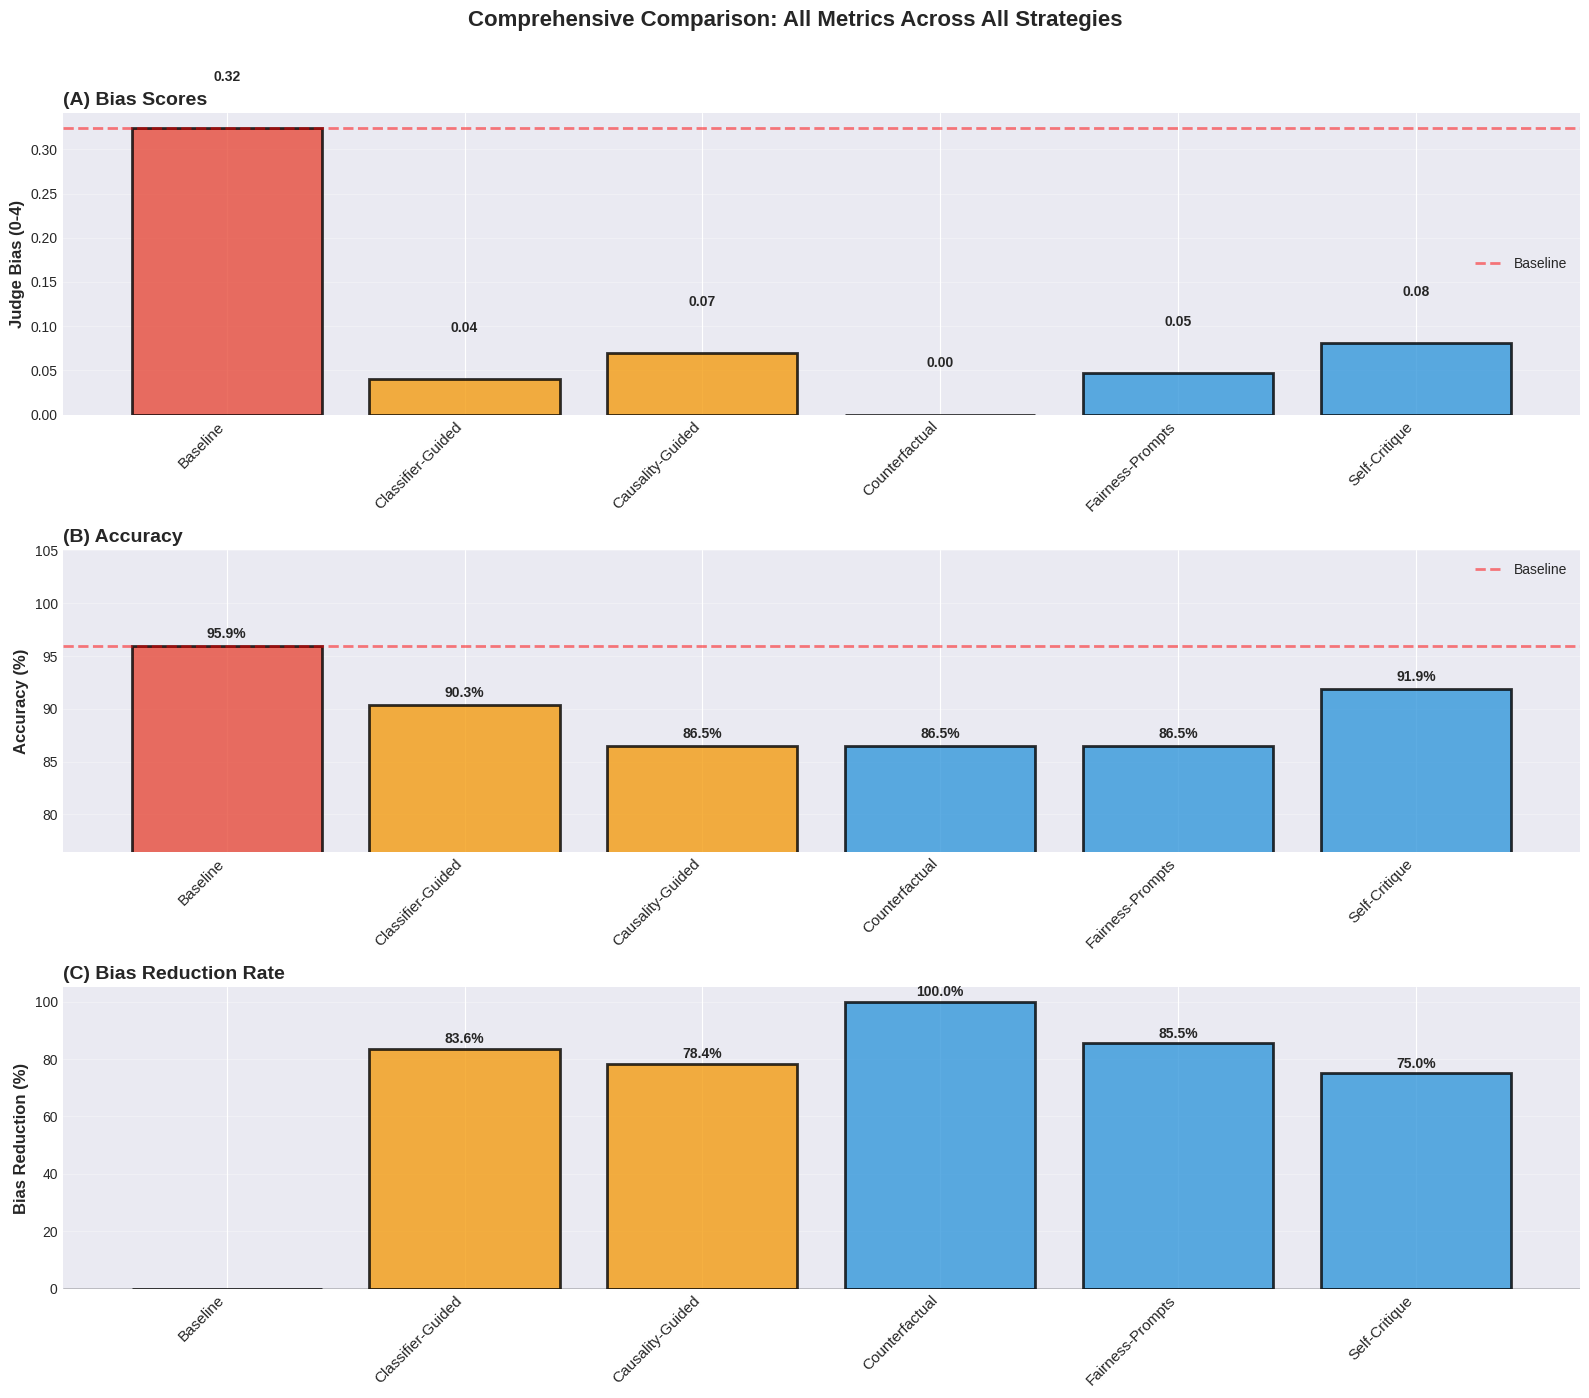

 Graph 4: comparison_comprehensive_all_metrics.png


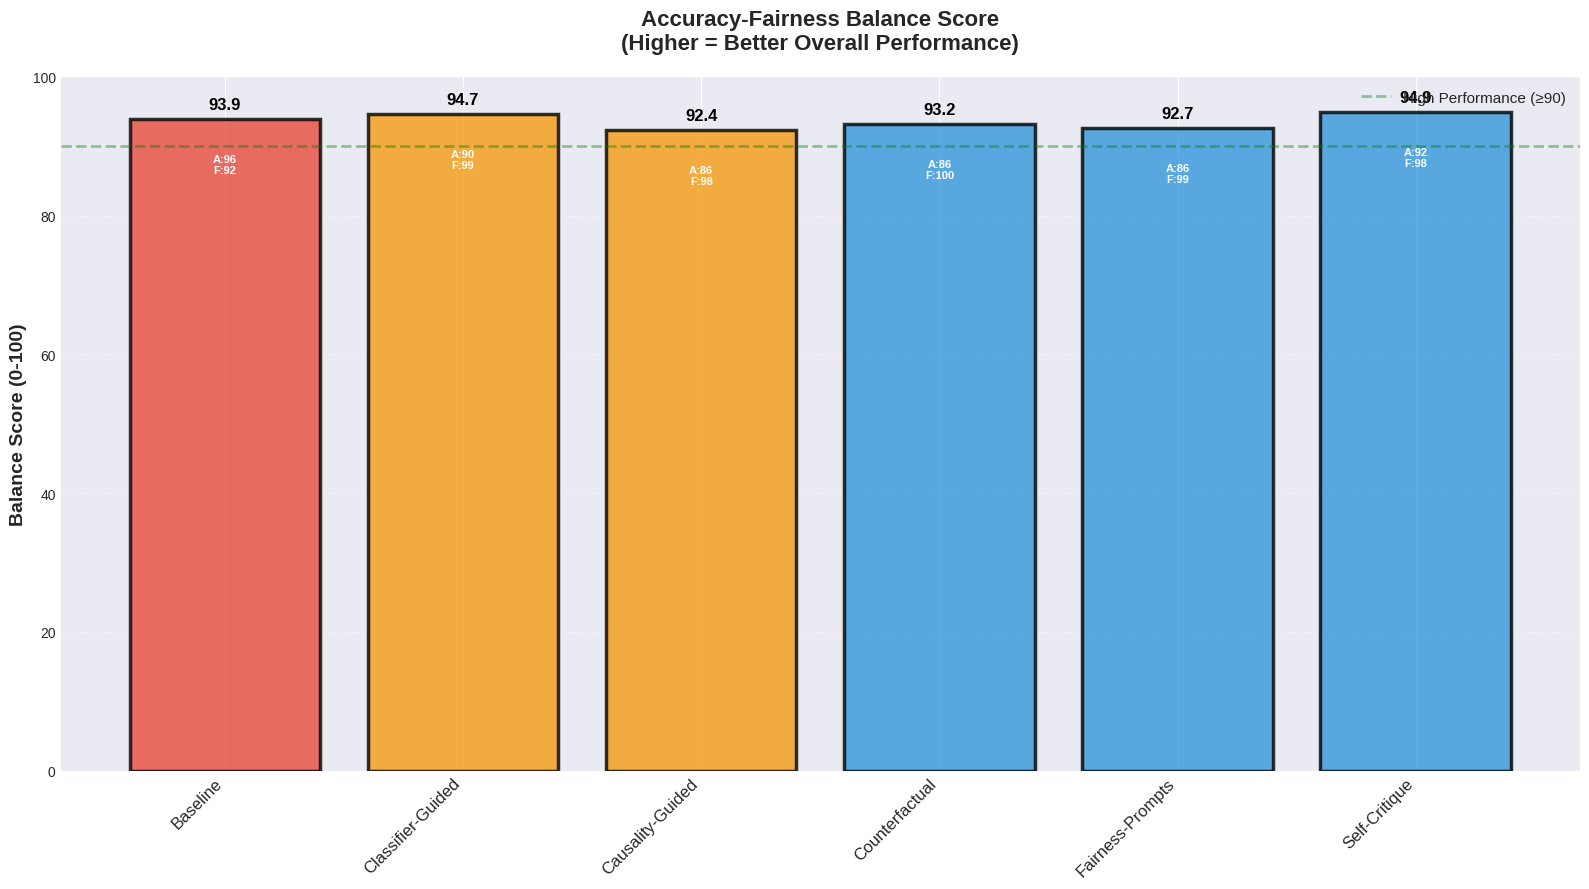

 Graph 5: comparison_balance_score.png

VISUALIZATION SUMMARY

  • Best Overall Balance: Self-Critique
    Balance Score: 94.9/100

  • Best Bias Reduction: Counterfactual
    Reduction: 100.0%

  • Best Accuracy: Baseline
    Accuracy: 95.9%

 ALL BAR GRAPHS COMPLETE!


In [ ]:
# CELL 6: COMPREHENSIVE BAR GRAPHS - ALL 5 STRATEGIES

import matplotlib.pyplot as plt
import numpy as np
import json
import os
from matplotlib.patches import Patch

print("="*80)
print("CREATING COMPREHENSIVE BAR GRAPHS")
print("="*80)

# ------------------------------------------------------------------------------
# 1. Force-Reload Baseline Data (The Fix)
# ------------------------------------------------------------------------------
# We reload this here to ensure 'baseline_acc' is calculated from the
# correct source file (95.9%) and not stale memory.
baseline_file_path = '/content/baseline_for_mitigation.json'
baseline_for_mitigation = []

if os.path.exists(baseline_file_path):
    with open(baseline_file_path, 'r') as f:
        baseline_for_mitigation = json.load(f)
    print(f"Refreshed baseline data: {len(baseline_for_mitigation)} samples loaded.")
else:
    print(f"Warning: {baseline_file_path} not found. Using existing data in memory.")

# ------------------------------------------------------------------------------
# 2. Calculate Metrics
# ------------------------------------------------------------------------------

# Calculate Baseline metrics directly from the reloaded data
baseline_judge = np.mean([r.get('baseline_mean_bias', 0) for r in baseline_for_mitigation])
baseline_acc = np.mean([r.get('baseline_correct', False) for r in baseline_for_mitigation]) * 100

print(f"Baseline Accuracy for Graph: {baseline_acc:.1f}%") # Should print 95.9%

# Prepare lists for plotting (Strategies + Baseline)
strategies_list = ['Baseline'] + list(comparison_results.keys())
judge_bias = [baseline_judge] + [comparison_results[n]['mitigated_judge'] for n in comparison_results.keys()]
accuracy = [baseline_acc] + [comparison_results[n]['accuracy'] for n in comparison_results.keys()]
reduction = [0.0] + [comparison_results[n]['reduction_percent'] for n in comparison_results.keys()]

# Define Colors
colors = ['#e74c3c']  # Baseline red
for n in comparison_results.keys():
    if 'Causality' in n or 'Classifier' in n:
        colors.append('#f39c12')  # Gold for novel approaches
    else:
        colors.append('#3498db')  # Blue for existing methods

# ------------------------------------------------------------------------------
# GRAPH 1: Side-by-Side Comparison (Bias & Accuracy)
# ------------------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Judge Bias
ax1 = axes[0]
bars1 = ax1.bar(range(len(strategies_list)), judge_bias,
                color=colors, alpha=0.8, edgecolor='black', linewidth=2.5)

ax1.set_xticks(range(len(strategies_list)))
ax1.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=12)
ax1.set_ylabel('Judge Bias Score (0-4)', fontsize=14, fontweight='bold')
ax1.set_title('Bias Comparison Across All Strategies', fontsize=16, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim([0, max(judge_bias) + 0.5])

# Add value labels
for bar, val in zip(bars1, judge_bias):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{val:.2f}', ha='center', va='bottom',
            fontsize=11, fontweight='bold')

# Plot 2: Accuracy
ax2 = axes[1]
bars2 = ax2.bar(range(len(strategies_list)), accuracy,
                color=colors, alpha=0.8, edgecolor='black', linewidth=2.5)

ax2.set_xticks(range(len(strategies_list)))
ax2.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax2.set_title('Accuracy Comparison Across All Strategies', fontsize=16, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim([min(accuracy) - 10, 105])

# Add value labels
for bar, val in zip(bars2, accuracy):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{val:.1f}%', ha='center', va='bottom',
            fontsize=11, fontweight='bold')

# Add legend
legend_elements = [
    Patch(facecolor='#e74c3c', edgecolor='black', label='Baseline'),
    Patch(facecolor='#3498db', edgecolor='black', label='Existing Methods'),
    Patch(facecolor='#f39c12', edgecolor='black', label='Novel Approaches ⭐')
]
ax2.legend(handles=legend_elements, loc='lower right', fontsize=11, framealpha=0.9)

plt.suptitle('Complete Strategy Comparison: Bias vs Accuracy',
            fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('comparison_bias_accuracy_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 1: comparison_bias_accuracy_bars.png")

# ------------------------------------------------------------------------------
# GRAPH 2: Grouped Bar Chart (All Metrics Together)
# ------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(16, 10))

x = np.arange(len(strategies_list))
width = 0.25

# Normalize bias for comparison (0-100 scale)
bias_normalized = [(b / 4.0) * 100 for b in judge_bias]
reduction_values = reduction

# Three metrics
bars1 = ax.bar(x - width, accuracy, width, label='Accuracy (%)',
              color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=2)
bars2 = ax.bar(x, bias_normalized, width, label='Bias (% of max)',
              color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=2)
bars3 = ax.bar(x + width, reduction_values, width, label='Reduction (%)',
              color='#3498db', alpha=0.8, edgecolor='black', linewidth=2)

ax.set_xlabel('Strategy', fontsize=14, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=14, fontweight='bold')
ax.set_title('Multi-Metric Comparison: All 5 Strategies',
            fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, 110])

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
               f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('comparison_grouped_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 2: comparison_grouped_bars.png")

# ------------------------------------------------------------------------------
# GRAPH 3: Reduction Rate Ranking (Horizontal Bars)
# ------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(14, 9))

# Sort by reduction (exclude baseline)
strategies_no_baseline = [s for s in strategies_list if s != 'Baseline']
reduction_no_baseline = [r for s, r in zip(strategies_list, reduction) if s != 'Baseline']

# Create tuples and sort
reduction_data = list(zip(strategies_no_baseline, reduction_no_baseline))
reduction_data.sort(key=lambda x: x[1], reverse=True)

names = [x[0] for x in reduction_data]
rates = [x[1] for x in reduction_data]

# Colors for ranking
bar_colors = []
for name in names:
    if 'Causality' in name or 'Classifier' in name:
        bar_colors.append('#f39c12')
    else:
        bar_colors.append('#2ecc71')

bars = ax.barh(range(len(names)), rates,
              color=bar_colors, alpha=0.8,
              edgecolor='black', linewidth=2.5)

ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=13)
ax.set_xlabel('Bias Reduction (%)', fontsize=14, fontweight='bold')
ax.set_title('Bias Reduction Rate Ranking - All Strategies',
            fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

for i, (bar, rate) in enumerate(zip(bars, rates), 1):
    ax.text(-5, bar.get_y() + bar.get_height()/2.,
           f'#{i}', ha='right', va='center',
           fontsize=14, fontweight='bold', color='black')
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2.,
           f'{rate:.1f}%', ha='left', va='center',
           fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('comparison_reduction_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 3: comparison_reduction_ranking.png")

# ------------------------------------------------------------------------------
# GRAPH 4: Comprehensive Comparison (All Metrics, All Strategies)
# ------------------------------------------------------------------------------

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Subplot 1: Bias
ax1 = axes[0]
bars1 = ax1.bar(range(len(strategies_list)), judge_bias,
               color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_xticks(range(len(strategies_list)))
ax1.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=11)
ax1.set_ylabel('Judge Bias (0-4)', fontsize=12, fontweight='bold')
ax1.set_title('(A) Bias Scores', fontsize=14, fontweight='bold', loc='left')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=baseline_judge, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')
ax1.legend()

for bar, val in zip(bars1, judge_bias):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
            f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Subplot 2: Accuracy
ax2 = axes[1]
bars2 = ax2.bar(range(len(strategies_list)), accuracy,
               color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(strategies_list)))
ax2.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=11)
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('(B) Accuracy', fontsize=14, fontweight='bold', loc='left')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([min(accuracy) - 10, 105])
ax2.axhline(y=baseline_acc, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')
ax2.legend()

for bar, val in zip(bars2, accuracy):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Subplot 3: Reduction
ax3 = axes[2]
bars3 = ax3.bar(range(len(strategies_list)), reduction,
               color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_xticks(range(len(strategies_list)))
ax3.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=11)
ax3.set_ylabel('Bias Reduction (%)', fontsize=12, fontweight='bold')
ax3.set_title('(C) Bias Reduction Rate', fontsize=14, fontweight='bold', loc='left')
ax3.grid(axis='y', alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)

for bar, val in zip(bars3, reduction):
    if val > 0:
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Comprehensive Comparison: All Metrics Across All Strategies',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('comparison_comprehensive_all_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 4: comparison_comprehensive_all_metrics.png")

# ------------------------------------------------------------------------------
# GRAPH 5: Accuracy-Fairness Balance Score
# ------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(16, 9))

# Calculate balance score: (Accuracy + Fairness) / 2
# Fairness = 1 - (bias / 4.0)
fairness_scores = [(1 - (b / 4.0)) * 100 for b in judge_bias]
balance_scores = [(a + f) / 2 for a, f in zip(accuracy, fairness_scores)]

bars = ax.bar(range(len(strategies_list)), balance_scores,
             color=colors, alpha=0.8, edgecolor='black', linewidth=2.5)

ax.set_xticks(range(len(strategies_list)))
ax.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Balance Score (0-100)', fontsize=14, fontweight='bold')
ax.set_title('Accuracy-Fairness Balance Score\n(Higher = Better Overall Performance)',
            fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, 100])

for bar, balance, acc, fair in zip(bars, balance_scores, accuracy, fairness_scores):
    # Main balance score
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
           f'{balance:.1f}', ha='center', va='bottom',
           fontsize=12, fontweight='bold', color='black')

    # Components (smaller text)
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() - 5,
           f'A:{acc:.0f}\nF:{fair:.0f}', ha='center', va='top',
           fontsize=8, color='white', fontweight='bold')

ax.axhline(y=90, color='green', linestyle='--', linewidth=2, alpha=0.4, label='High Performance (≥90)')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('comparison_balance_score.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 5: comparison_balance_score.png")

# ------------------------------------------------------------------------------
# Summary
# ------------------------------------------------------------------------------

print("\n" + "="*80)
print("VISUALIZATION SUMMARY")
print("="*80)

best_balance_idx = balance_scores.index(max(balance_scores))
best_balance_name = strategies_list[best_balance_idx]

print(f"\n  • Best Overall Balance: {best_balance_name}")
print(f"    Balance Score: {balance_scores[best_balance_idx]:.1f}/100")

best_red_idx = reduction.index(max(reduction))
best_red_name = strategies_list[best_red_idx]
print(f"\n  • Best Bias Reduction: {best_red_name}")
print(f"    Reduction: {reduction[best_red_idx]:.1f}%")

best_acc_idx = accuracy.index(max(accuracy))
best_acc_name = strategies_list[best_acc_idx]
print(f"\n  • Best Accuracy: {best_acc_name}")
print(f"    Accuracy: {accuracy[best_acc_idx]:.1f}%")

print("\n" + "="*80)
print(" ALL BAR GRAPHS COMPLETE!")
print("="*80)

CREATING COMPREHENSIVE BAR GRAPHS


/tmp/ipython-input-164486870.py:82: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-164486870.py:83: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Liberation Sans.
  plt.savefig('comparison_bias_accuracy_bars.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


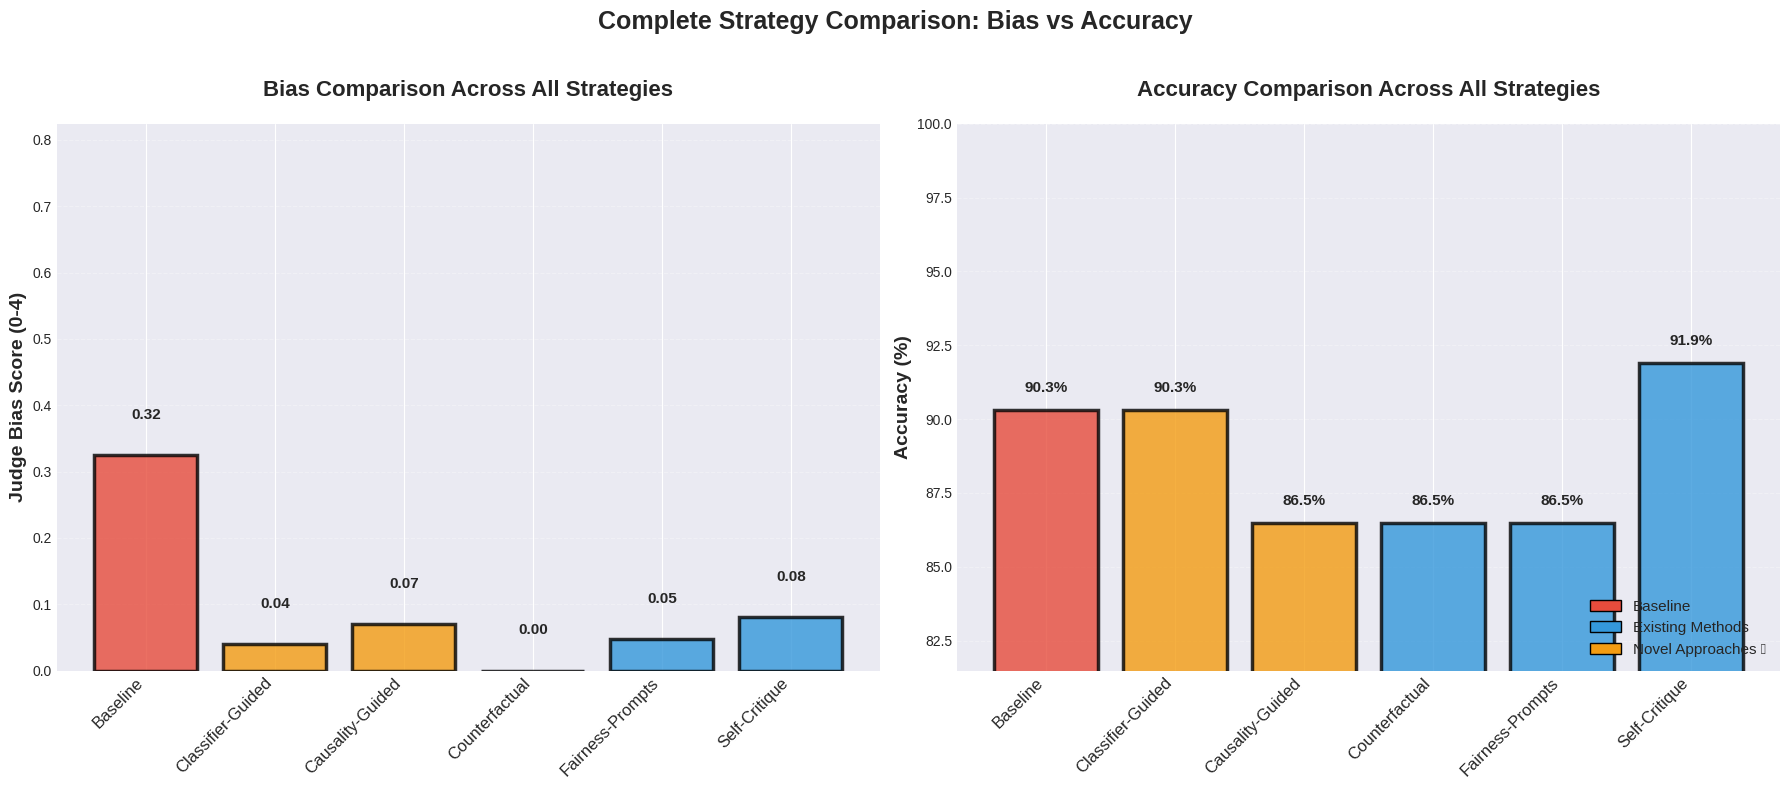

 Graph 1: comparison_bias_accuracy_bars.png


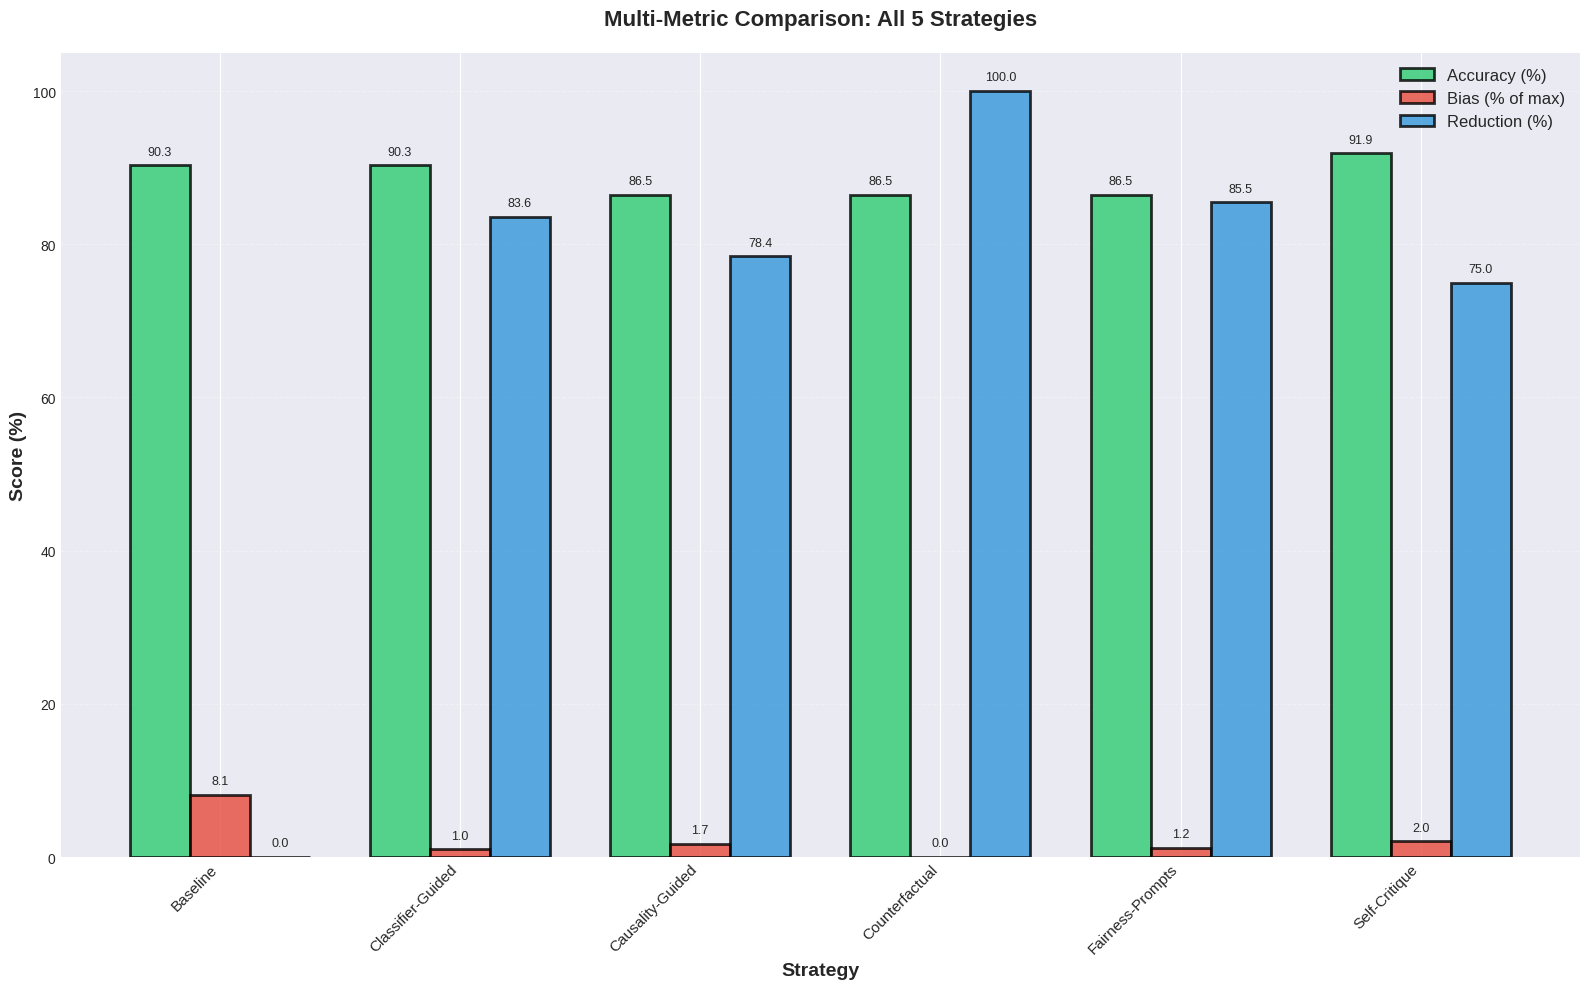

 Graph 2: comparison_grouped_bars.png


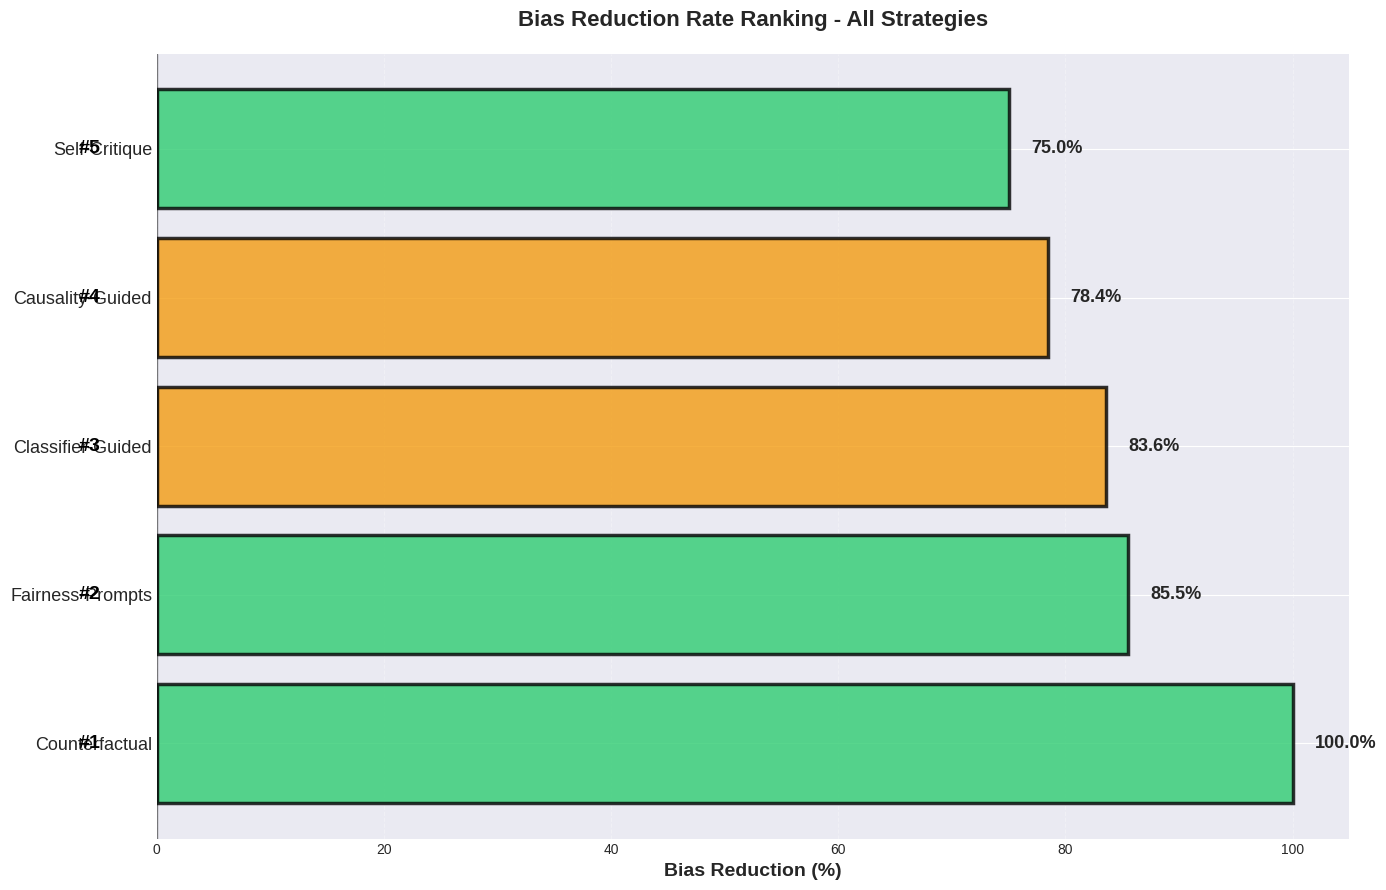

 Graph 3: comparison_reduction_ranking.png


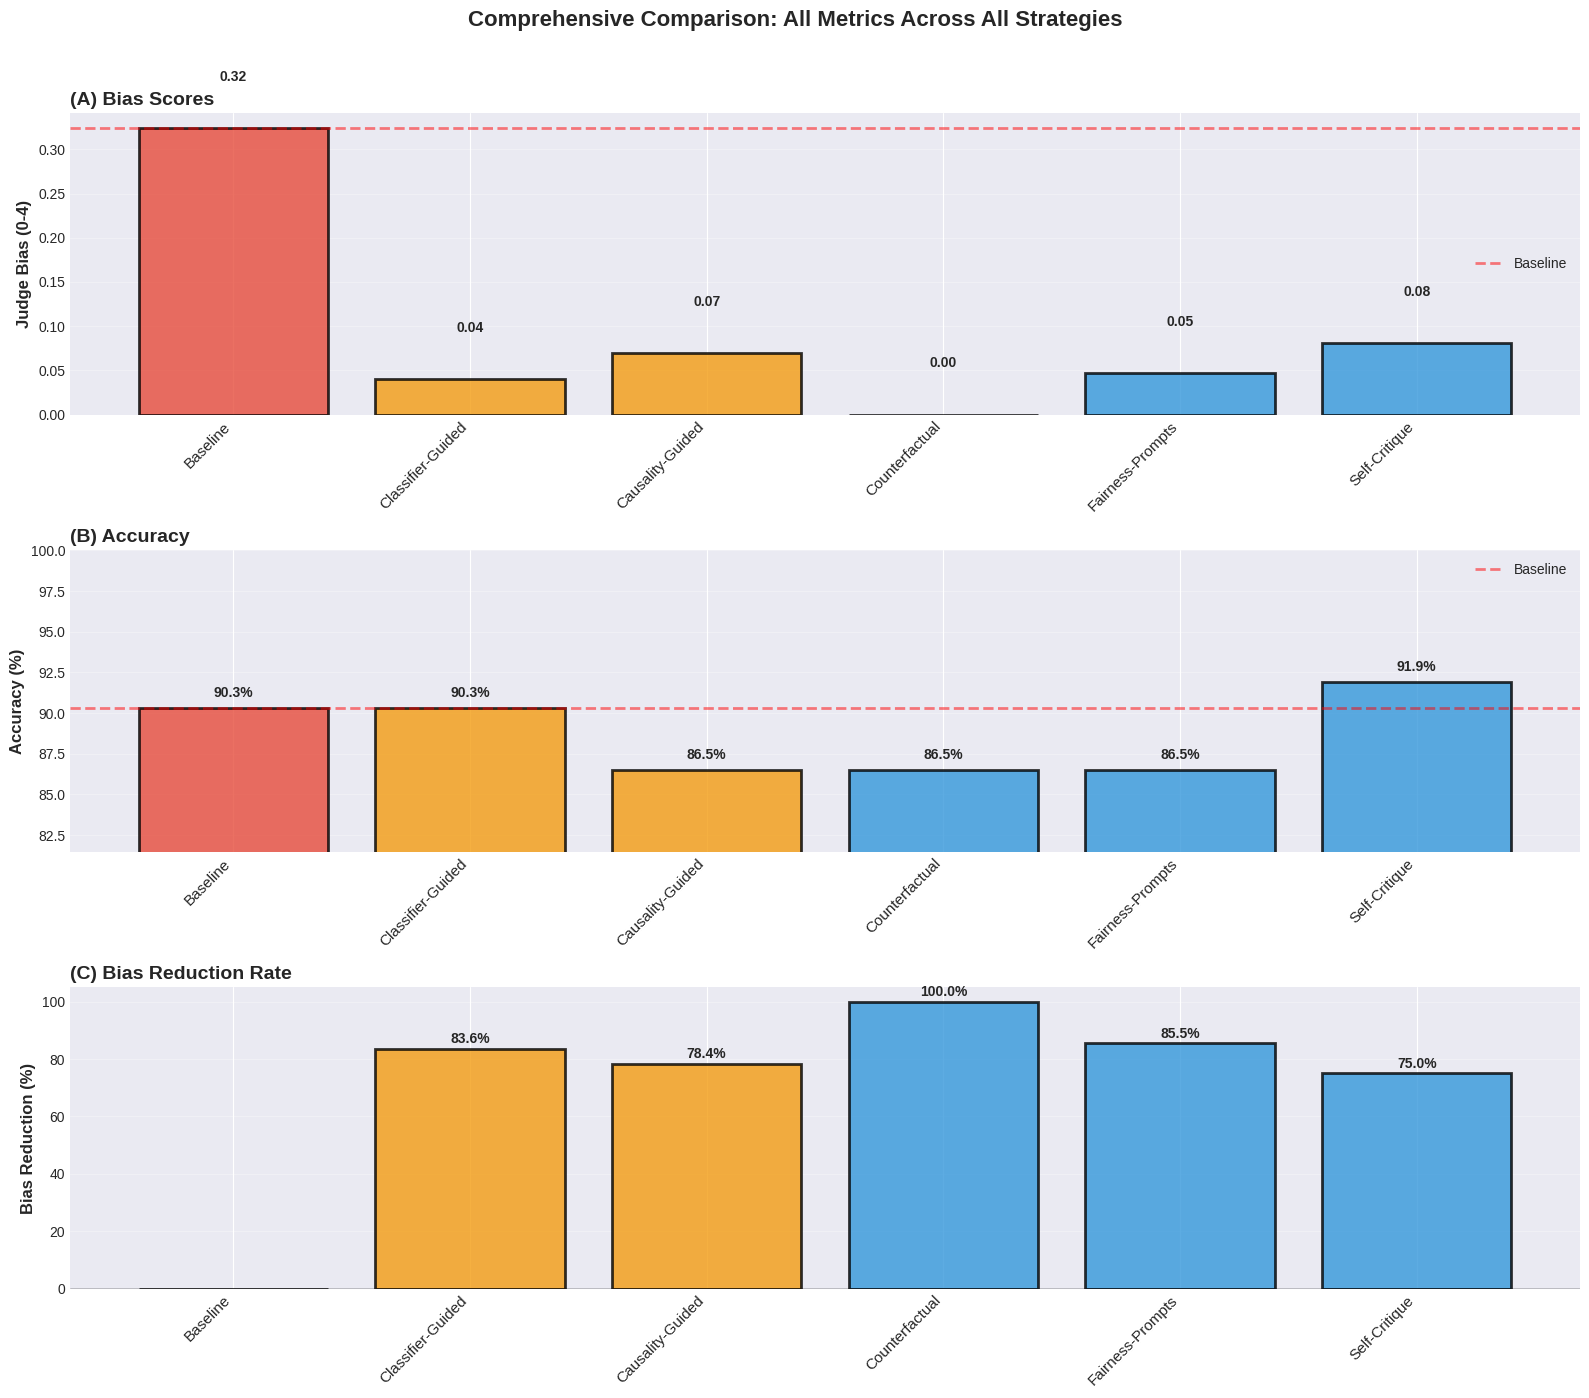

 Graph 4: comparison_comprehensive_all_metrics.png


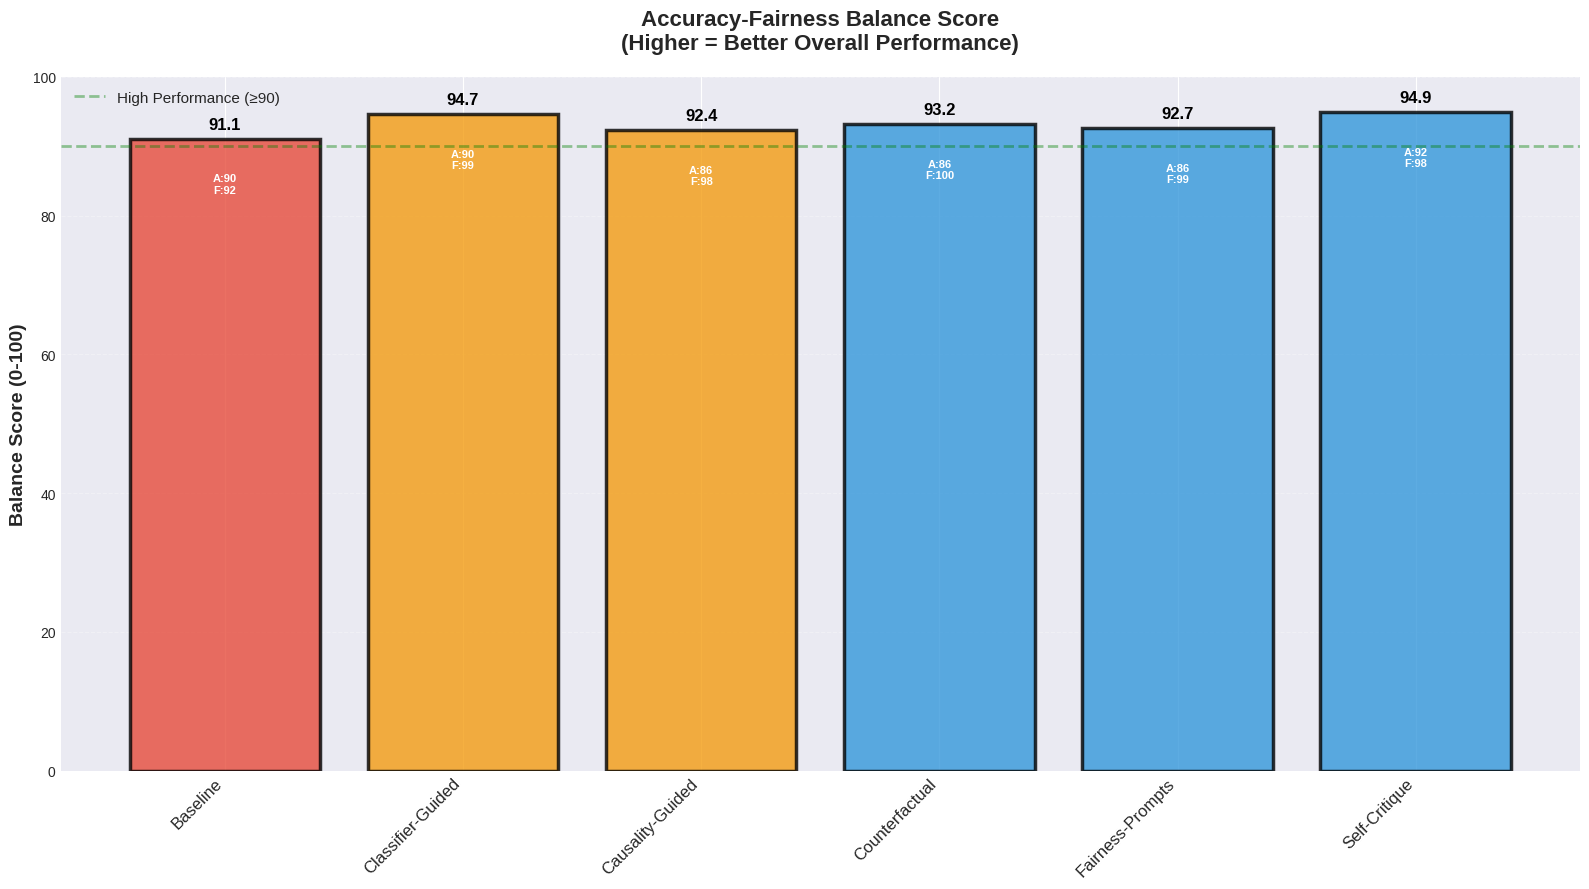

 Graph 5: comparison_balance_score.png

VISUALIZATION SUMMARY

 Generated 5 comprehensive bar graphs:

  1. comparison_bias_accuracy_bars.png
     • Side-by-side: Bias vs Accuracy
     • Shows tradeoff clearly

  2. comparison_grouped_bars.png
     • Grouped bars: All metrics together
     • Easy to compare within each strategy

  3. comparison_reduction_ranking.png
     • Horizontal bars ranked by reduction
     • Shows which strategy reduces bias most

  4. comparison_comprehensive_all_metrics.png
     • Stacked 3-panel comparison
     • Bias + Accuracy + Reduction in one figure

  5. comparison_balance_score.png
     • Overall balance score (Accuracy + Fairness)
     • Single metric for overall performance

 KEY INSIGHTS:

  • Best Overall Balance: Self-Critique
    Balance Score: 94.9/100

  • Best Bias Reduction: Counterfactual
    Reduction: 100.0%

  • Best Accuracy: Self-Critique
    Accuracy: 91.9%

 ALL BAR GRAPHS COMPLETE!


In [ ]:
# CELL 6: COMPREHENSIVE BAR GRAPHS - ALL 5 STRATEGIES

print("="*80)
print("CREATING COMPREHENSIVE BAR GRAPHS")
print("="*80)

# Prepare data
baseline_judge = np.mean([r['baseline_mean_bias'] for r in baseline_for_mitigation])

# Calculate baseline accuracy from the mitigation results
first_strategy_results = all_mitigation_results[list(all_mitigation_results.keys())[0]]
baseline_acc = np.mean([r.get('is_correct', False) for r in first_strategy_results]) * 100

strategies_list = ['Baseline'] + list(comparison_results.keys())
judge_bias = [baseline_judge] + [comparison_results[n]['mitigated_judge'] for n in comparison_results.keys()]
accuracy = [baseline_acc] + [comparison_results[n]['accuracy'] for n in comparison_results.keys()]
reduction = [0.0] + [comparison_results[n]['reduction_percent'] for n in comparison_results.keys()]

# Colors
colors = ['#e74c3c']  # Baseline red
for n in comparison_results.keys():
    if 'Causality' in n or 'Classifier' in n:
        colors.append('#f39c12')  # Gold for novel
    else:
        colors.append('#3498db')  # Blue for existing

################################################################################
# GRAPH 1: Side-by-Side Comparison (Bias & Accuracy)
################################################################################

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Judge Bias
ax1 = axes[0]
bars1 = ax1.bar(range(len(strategies_list)), judge_bias,
                color=colors, alpha=0.8, edgecolor='black', linewidth=2.5)

ax1.set_xticks(range(len(strategies_list)))
ax1.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=12)
ax1.set_ylabel('Judge Bias Score (0-4)', fontsize=14, fontweight='bold')
ax1.set_title('Bias Comparison Across All Strategies', fontsize=16, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim([0, max(judge_bias) + 0.5])

# Add value labels on bars
for bar, val in zip(bars1, judge_bias):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{val:.2f}', ha='center', va='bottom',
            fontsize=11, fontweight='bold')

# Plot 2: Accuracy
ax2 = axes[1]
bars2 = ax2.bar(range(len(strategies_list)), accuracy,
                color=colors, alpha=0.8, edgecolor='black', linewidth=2.5)

ax2.set_xticks(range(len(strategies_list)))
ax2.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax2.set_title('Accuracy Comparison Across All Strategies', fontsize=16, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim([min(accuracy) - 5, 100])

# Add value labels
for bar, val in zip(bars2, accuracy):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{val:.1f}%', ha='center', va='bottom',
            fontsize=11, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', edgecolor='black', label='Baseline'),
    Patch(facecolor='#3498db', edgecolor='black', label='Existing Methods'),
    Patch(facecolor='#f39c12', edgecolor='black', label='Novel Approaches ⭐')
]
ax2.legend(handles=legend_elements, loc='lower right', fontsize=11, framealpha=0.9)

plt.suptitle('Complete Strategy Comparison: Bias vs Accuracy',
            fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('comparison_bias_accuracy_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 1: comparison_bias_accuracy_bars.png")

################################################################################
# GRAPH 2: Grouped Bar Chart (All Metrics Together)
################################################################################

fig, ax = plt.subplots(figsize=(16, 10))

x = np.arange(len(strategies_list))
width = 0.25

# Normalize for comparison (0-100 scale)
bias_normalized = [(b / 4.0) * 100 for b in judge_bias]
reduction_values = reduction

# Three metrics
bars1 = ax.bar(x - width, accuracy, width, label='Accuracy (%)',
              color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=2)
bars2 = ax.bar(x, bias_normalized, width, label='Bias (% of max)',
              color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=2)
bars3 = ax.bar(x + width, reduction_values, width, label='Reduction (%)',
              color='#3498db', alpha=0.8, edgecolor='black', linewidth=2)

ax.set_xlabel('Strategy', fontsize=14, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=14, fontweight='bold')
ax.set_title('Multi-Metric Comparison: All 5 Strategies',
            fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, 105])

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
               f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('comparison_grouped_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 2: comparison_grouped_bars.png")

################################################################################
# GRAPH 3: Reduction Rate Ranking (Horizontal Bars)
################################################################################

fig, ax = plt.subplots(figsize=(14, 9))

# Sort by reduction (exclude baseline)
strategies_no_baseline = [s for s in strategies_list if s != 'Baseline']
reduction_no_baseline = [r for s, r in zip(strategies_list, reduction) if s != 'Baseline']

# Create tuples and sort
reduction_data = list(zip(strategies_no_baseline, reduction_no_baseline))
reduction_data.sort(key=lambda x: x[1], reverse=True)

names = [x[0] for x in reduction_data]
rates = [x[1] for x in reduction_data]

# Colors for ranking
bar_colors = []
for name in names:
    if 'Causality' in name or 'Classifier' in name:
        bar_colors.append('#f39c12')
    else:
        bar_colors.append('#2ecc71')

bars = ax.barh(range(len(names)), rates,
              color=bar_colors, alpha=0.8,
              edgecolor='black', linewidth=2.5)

ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=13)
ax.set_xlabel('Bias Reduction (%)', fontsize=14, fontweight='bold')
ax.set_title('Bias Reduction Rate Ranking - All Strategies',
            fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Add rank numbers and value labels
for i, (bar, rate) in enumerate(zip(bars, rates), 1):
    # Rank number (left)
    ax.text(-5, bar.get_y() + bar.get_height()/2.,
           f'#{i}', ha='right', va='center',
           fontsize=14, fontweight='bold', color='black')

    # Value (right)
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2.,
           f'{rate:.1f}%', ha='left', va='center',
           fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('comparison_reduction_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 3: comparison_reduction_ranking.png")

################################################################################
# GRAPH 4: Comprehensive Comparison (All Metrics, All Strategies)
################################################################################

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Subplot 1: Bias
ax1 = axes[0]
bars1 = ax1.bar(range(len(strategies_list)), judge_bias,
               color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_xticks(range(len(strategies_list)))
ax1.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=11)
ax1.set_ylabel('Judge Bias (0-4)', fontsize=12, fontweight='bold')
ax1.set_title('(A) Bias Scores', fontsize=14, fontweight='bold', loc='left')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=baseline_judge, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')
ax1.legend()

for bar, val in zip(bars1, judge_bias):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
            f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Subplot 2: Accuracy
ax2 = axes[1]
bars2 = ax2.bar(range(len(strategies_list)), accuracy,
               color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(strategies_list)))
ax2.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=11)
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('(B) Accuracy', fontsize=14, fontweight='bold', loc='left')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([min(accuracy) - 5, 100])
ax2.axhline(y=baseline_acc, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')
ax2.legend()

for bar, val in zip(bars2, accuracy):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Subplot 3: Reduction
ax3 = axes[2]
bars3 = ax3.bar(range(len(strategies_list)), reduction,
               color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_xticks(range(len(strategies_list)))
ax3.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=11)
ax3.set_ylabel('Bias Reduction (%)', fontsize=12, fontweight='bold')
ax3.set_title('(C) Bias Reduction Rate', fontsize=14, fontweight='bold', loc='left')
ax3.grid(axis='y', alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)

for bar, val in zip(bars3, reduction):
    if val > 0:
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Comprehensive Comparison: All Metrics Across All Strategies',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('comparison_comprehensive_all_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 4: comparison_comprehensive_all_metrics.png")

################################################################################
# GRAPH 5: Accuracy-Fairness Balance Score
################################################################################

fig, ax = plt.subplots(figsize=(16, 9))

# Calculate balance score: (Accuracy + Fairness) / 2
# Fairness = 1 - (bias / 4.0)
fairness_scores = [(1 - (b / 4.0)) * 100 for b in judge_bias]
balance_scores = [(a + f) / 2 for a, f in zip(accuracy, fairness_scores)]

bars = ax.bar(range(len(strategies_list)), balance_scores,
             color=colors, alpha=0.8, edgecolor='black', linewidth=2.5)

ax.set_xticks(range(len(strategies_list)))
ax.set_xticklabels(strategies_list, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Balance Score (0-100)', fontsize=14, fontweight='bold')
ax.set_title('Accuracy-Fairness Balance Score\n(Higher = Better Overall Performance)',
            fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, 100])

# Add value labels with components
for bar, balance, acc, fair in zip(bars, balance_scores, accuracy, fairness_scores):
    # Main balance score
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
           f'{balance:.1f}', ha='center', va='bottom',
           fontsize=12, fontweight='bold', color='black')

    # Components (smaller text)
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() - 5,
           f'A:{acc:.0f}\nF:{fair:.0f}', ha='center', va='top',
           fontsize=8, color='white', fontweight='bold')

# Add horizontal line for "good" threshold
ax.axhline(y=90, color='green', linestyle='--', linewidth=2, alpha=0.4, label='High Performance (≥90)')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('comparison_balance_score.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 5: comparison_balance_score.png")

################################################################################
# Summary
################################################################################

print("\n" + "="*80)
print("VISUALIZATION SUMMARY")
print("="*80)

print("\n Generated 5 comprehensive bar graphs:")
print("\n  1. comparison_bias_accuracy_bars.png")
print("     • Side-by-side: Bias vs Accuracy")
print("     • Shows tradeoff clearly")

print("\n  2. comparison_grouped_bars.png")
print("     • Grouped bars: All metrics together")
print("     • Easy to compare within each strategy")

print("\n  3. comparison_reduction_ranking.png")
print("     • Horizontal bars ranked by reduction")
print("     • Shows which strategy reduces bias most")

print("\n  4. comparison_comprehensive_all_metrics.png")
print("     • Stacked 3-panel comparison")
print("     • Bias + Accuracy + Reduction in one figure")

print("\n  5. comparison_balance_score.png")
print("     • Overall balance score (Accuracy + Fairness)")
print("     • Single metric for overall performance")

print("\n KEY INSIGHTS:")

best_balance_idx = balance_scores.index(max(balance_scores))
best_balance_name = strategies_list[best_balance_idx]

print(f"\n  • Best Overall Balance: {best_balance_name}")
print(f"    Balance Score: {balance_scores[best_balance_idx]:.1f}/100")

best_red_idx = reduction.index(max(reduction))
best_red_name = strategies_list[best_red_idx]
print(f"\n  • Best Bias Reduction: {best_red_name}")
print(f"    Reduction: {reduction[best_red_idx]:.1f}%")

best_acc_idx = accuracy.index(max(accuracy))
best_acc_name = strategies_list[best_acc_idx]
print(f"\n  • Best Accuracy: {best_acc_name}")
print(f"    Accuracy: {accuracy[best_acc_idx]:.1f}%")

print("\n" + "="*80)
print(" ALL BAR GRAPHS COMPLETE!")
print("="*80)

/tmp/ipython-input-309897870.py:70: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-309897870.py:71: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Liberation Sans.
  plt.savefig('mitigation_hybrid_comparison.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


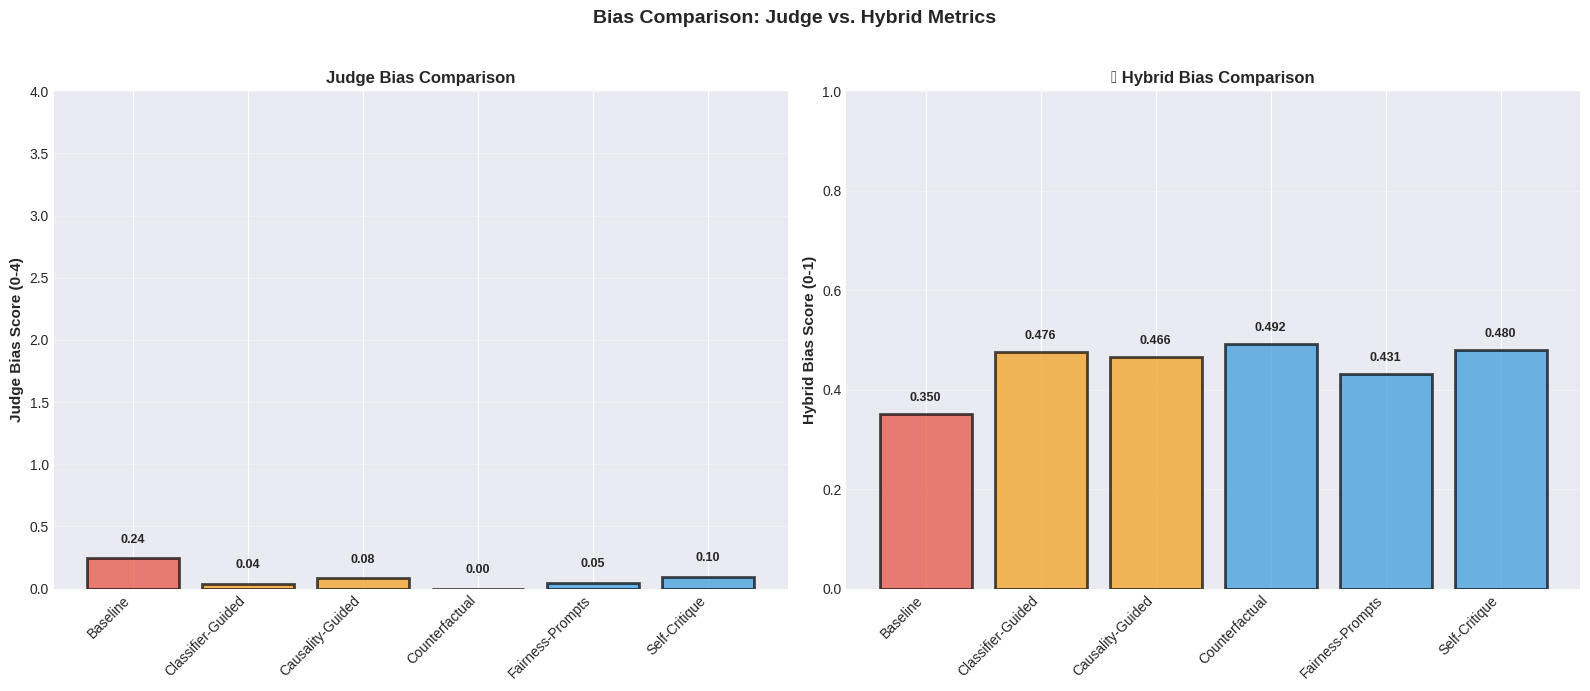

 Saved: mitigation_hybrid_comparison.png


In [ ]:
# CELL: PLOT - Judge vs Hybrid Comparison

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Get baseline means (use full baseline data)
baseline_judge_mean = np.mean([r['baseline_mean_bias'] for r in baseline_for_mitigation])
baseline_hybrid_mean = np.mean([r['baseline_hybrid'] for r in baseline_for_mitigation])

# Plot 1: Judge Scores
ax1 = axes[0]
judge_means = [baseline_judge_mean]
names = ['Baseline']

# Get mitigation means (using actual results, handling missing samples)
for name in strategies.keys():
    if name in stats_results and 'mitigated_judge' in stats_results[name]:
        judge_means.append(stats_results[name]['mitigated_judge'])
        names.append(name)
    elif name in all_mitigation_results:
        # Fallback: calculate from results directly
        mean_val = np.mean([r['mean_step_bias'] for r in all_mitigation_results[name]])
        judge_means.append(mean_val)
        names.append(name)

# Colors
colors = ['#e74c3c']  # Baseline red
for n in names[1:]:
    colors.append('#f39c12' if 'NOVEL' in n or 'Causality' in n or 'Classifier' in n else '#3498db')

bars1 = ax1.bar(range(len(names)), judge_means,
               color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels(names, rotation=45, ha='right', fontsize=10)
ax1.set_ylabel('Judge Bias Score (0-4)', fontsize=11, fontweight='bold')
ax1.set_title('Judge Bias Comparison', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 4])

for bar, val in zip(bars1, judge_means):
    ax1.text(bar.get_x() + bar.get_width()/2., val + 0.1,
             f'{val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Hybrid Scores
ax2 = axes[1]
hybrid_means = [baseline_hybrid_mean]

for name in strategies.keys():
    if name in stats_results and 'mitigated_hybrid' in stats_results[name]:
        hybrid_means.append(stats_results[name]['mitigated_hybrid'])
    elif name in all_mitigation_results:
        # Fallback: calculate from results
        mean_val = np.mean([r['hybrid_bias_score'] for r in all_mitigation_results[name]])
        hybrid_means.append(mean_val)

bars2 = ax2.bar(range(len(names)), hybrid_means,
               color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels(names, rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Hybrid Bias Score (0-1)', fontsize=11, fontweight='bold')
ax2.set_title('⭐ Hybrid Bias Comparison', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1])

for bar, val in zip(bars2, hybrid_means):
    ax2.text(bar.get_x() + bar.get_width()/2., val + 0.02,
             f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Bias Comparison: Judge vs. Hybrid Metrics',
            fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('mitigation_hybrid_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: mitigation_hybrid_comparison.png")

MULTI-MODEL COMPARISON - ACCURACY & BIAS


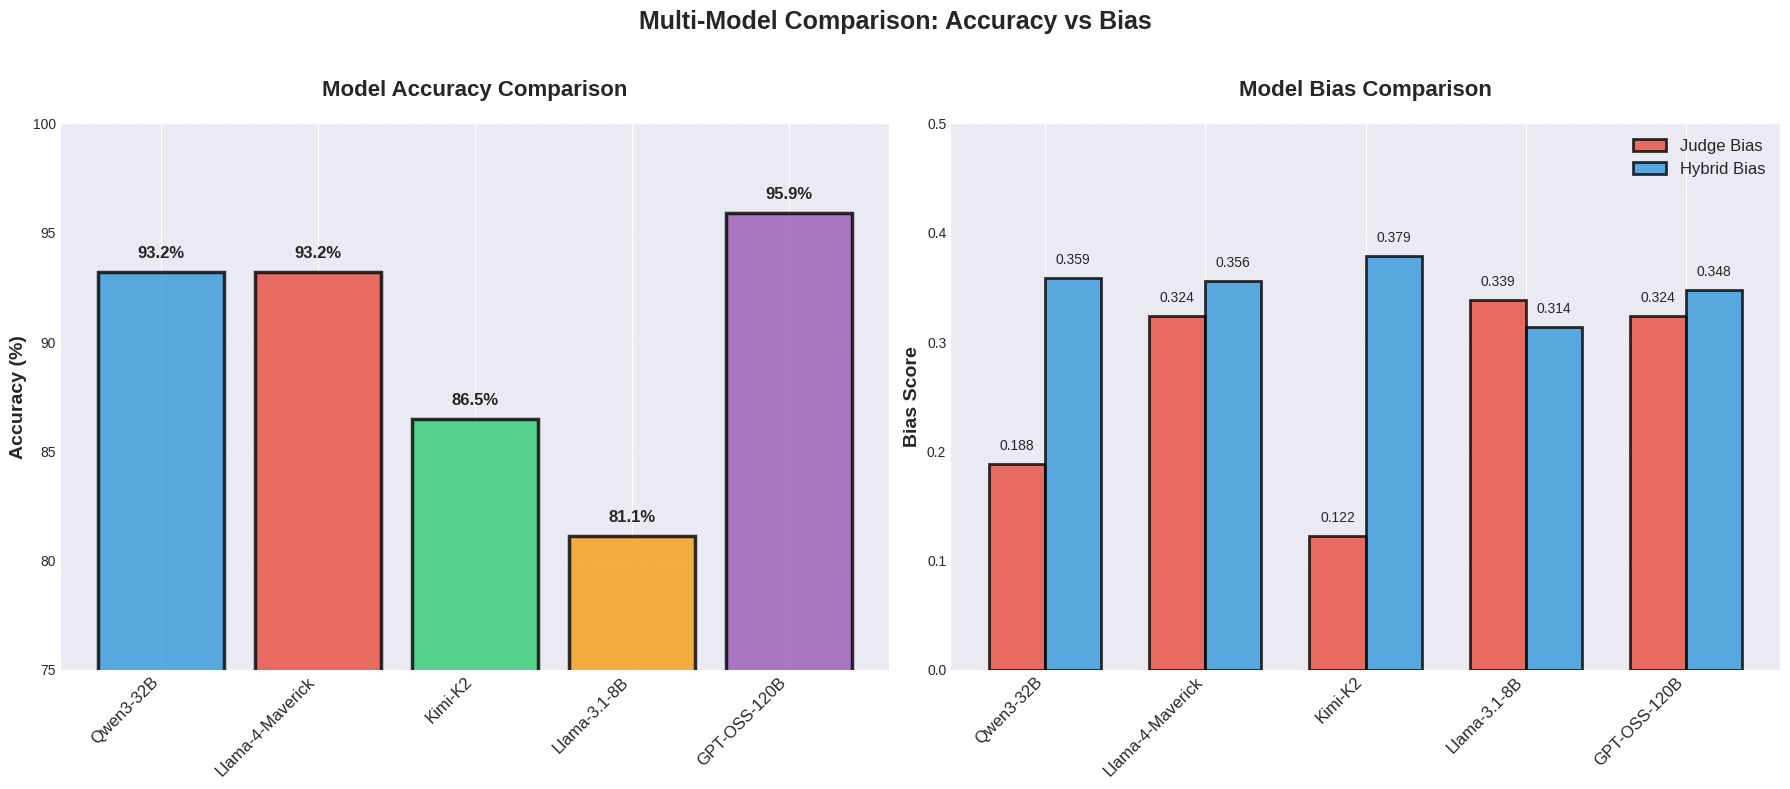

 Graph 1: model_comparison_accuracy_bias.png


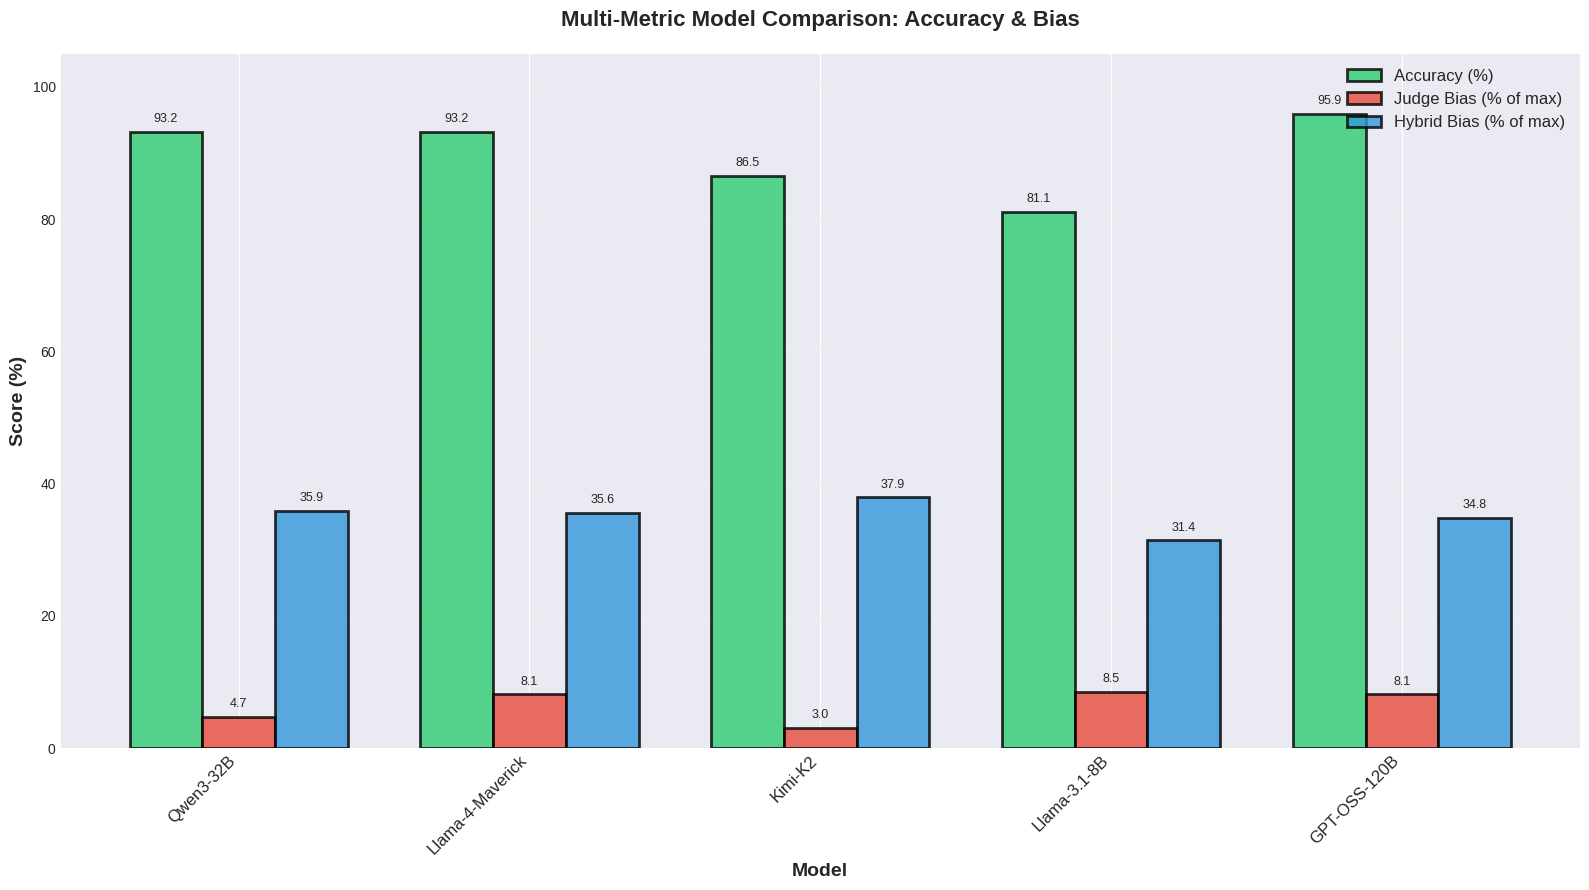

 Graph 2: model_comparison_grouped_metrics.png


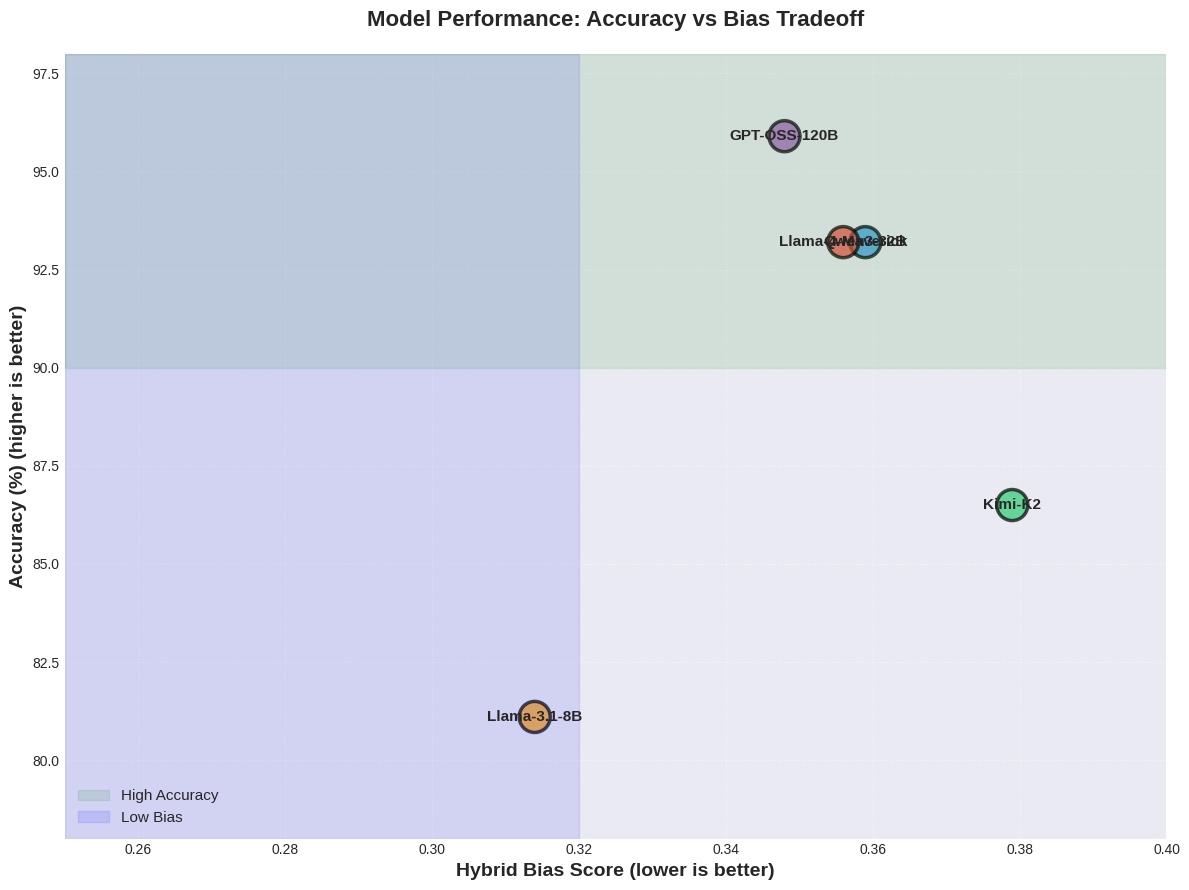

 Graph 3: model_comparison_tradeoff_scatter.png


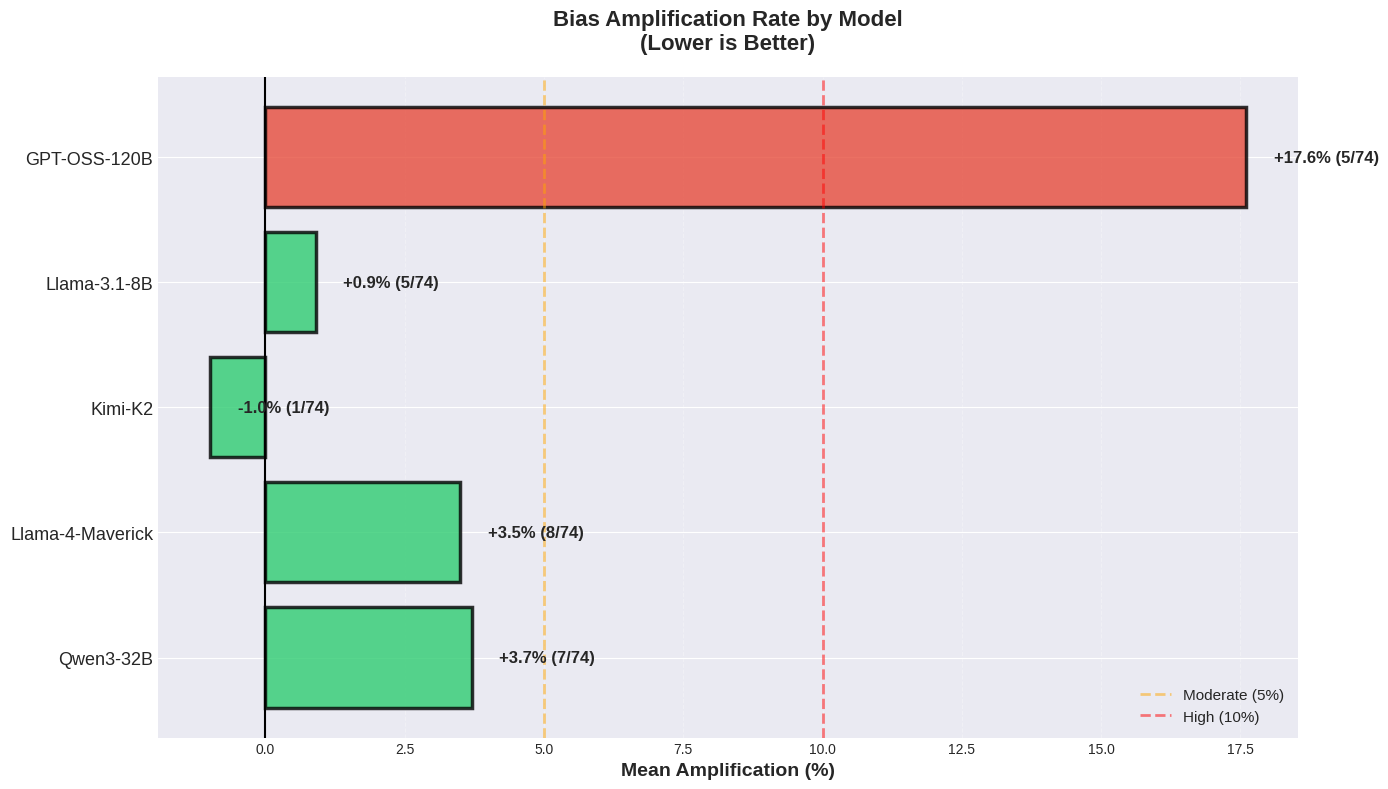

 Graph 4: model_comparison_amplification.png

SUMMARY STATISTICS

 Model Rankings:

1. Best Accuracy:
   1. GPT-OSS-120B        : 95.9%
   2. Qwen3-32B           : 93.2%
   3. Llama-4-Maverick    : 93.2%
   4. Kimi-K2             : 86.5%
   5. Llama-3.1-8B        : 81.1%

2. Lowest Judge Bias:
   1. Kimi-K2             : 0.122
   2. Qwen3-32B           : 0.188
   3. Llama-4-Maverick    : 0.324
   4. GPT-OSS-120B        : 0.324
   5. Llama-3.1-8B        : 0.339

3. Lowest Hybrid Bias:
   1. Llama-3.1-8B        : 0.314
   2. GPT-OSS-120B        : 0.348
   3. Llama-4-Maverick    : 0.356
   4. Qwen3-32B           : 0.359
   5. Kimi-K2             : 0.379

4. Lowest Amplification:
   1. Kimi-K2             : -1.0%
   2. Llama-3.1-8B        : +0.9%
   3. Llama-4-Maverick    : +3.5%
   4. Qwen3-32B           : +3.7%
   5. GPT-OSS-120B        : +17.6%

KEY FINDINGS:

 Best Accuracy: GPT-OSS-120B (95.9%)
 Lowest Judge Bias: Kimi-K2 (0.122)
 Lowest Hybrid Bias: Llama-3.1-8B (0.314)
 Lowest Ampli

In [ ]:
# MULTI-MODEL COMPARISON BAR GRAPH
# Compares Accuracy and Bias across all 5 models

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

print("="*80)
print("MULTI-MODEL COMPARISON - ACCURACY & BIAS")
print("="*80)

# ============================================================================
# MODEL DATA (from your screenshots)
# ============================================================================

models = {
    'Qwen3-32B': {
        'accuracy': 93.2,
        'judge_bias': 0.188,
        'hybrid_bias': 0.359,
        'amplification': 3.7,
        'amplifying_samples': 7,
        'total_samples': 74
    },
    'Llama-4-Maverick': {
        'accuracy': 93.2,
        'judge_bias': 0.324,
        'hybrid_bias': 0.356,
        'amplification': 3.5,
        'amplifying_samples': 8,
        'total_samples': 74
    },
    'Kimi-K2': {
        'accuracy': 86.5,
        'judge_bias': 0.122,
        'hybrid_bias': 0.379,
        'amplification': -1.0,
        'amplifying_samples': 1,
        'total_samples': 74
    },
    'Llama-3.1-8B': {
        'accuracy': 81.1,
        'judge_bias': 0.339,
        'hybrid_bias': 0.314,
        'amplification': 0.9,
        'amplifying_samples': 5,
        'total_samples': 74
    },
    'GPT-OSS-120B': {
        'accuracy': 95.9,
        'judge_bias': 0.324,
        'hybrid_bias': 0.348,
        'amplification': 17.6,
        'amplifying_samples': 5,
        'total_samples': 74
    }
}

# ============================================================================
# VISUALIZATION 1: Side-by-Side Accuracy and Bias
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

model_names = list(models.keys())
accuracies = [models[m]['accuracy'] for m in model_names]
judge_biases = [models[m]['judge_bias'] for m in model_names]
hybrid_biases = [models[m]['hybrid_bias'] for m in model_names]

# Colors for each model
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# Plot 1: Accuracy Comparison
ax1 = axes[0]
bars1 = ax1.bar(range(len(model_names)), accuracies,
                color=colors, alpha=0.8, edgecolor='black', linewidth=2.5)

ax1.set_xticks(range(len(model_names)))
ax1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim([75, 100])

# Add value labels on bars
for bar, val in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{val:.1f}%', ha='center', va='bottom',
            fontsize=12, fontweight='bold')

# Plot 2: Bias Comparison (Judge + Hybrid)
ax2 = axes[1]
x = np.arange(len(model_names))
width = 0.35

bars2a = ax2.bar(x - width/2, judge_biases, width, label='Judge Bias',
                 color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=2)
bars2b = ax2.bar(x + width/2, hybrid_biases, width, label='Hybrid Bias',
                 color='#3498db', alpha=0.8, edgecolor='black', linewidth=2)

ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45, ha='right', fontsize=12)
ax2.set_ylabel('Bias Score', fontsize=14, fontweight='bold')
ax2.set_title('Model Bias Comparison', fontsize=16, fontweight='bold', pad=20)
ax2.legend(fontsize=12, loc='upper right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim([0, 0.5])

# Add value labels
for bar in bars2a:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

for bar in bars2b:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Multi-Model Comparison: Accuracy vs Bias',
            fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('model_comparison_accuracy_bias.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 1: model_comparison_accuracy_bias.png")

# ============================================================================
# VISUALIZATION 2: Combined Metrics (Grouped Bar Chart)
# ============================================================================

fig, ax = plt.subplots(figsize=(16, 9))

x = np.arange(len(model_names))
width = 0.25

# Normalize metrics to 0-100 scale for comparison
accuracies_norm = accuracies  # Already 0-100
judge_norm = [(b / 4.0) * 100 for b in judge_biases]  # Judge bias 0-4 scale
hybrid_norm = [b * 100 for b in hybrid_biases]  # Hybrid bias 0-1 scale

bars1 = ax.bar(x - width, accuracies_norm, width, label='Accuracy (%)',
              color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=2)
bars2 = ax.bar(x, judge_norm, width, label='Judge Bias (% of max)',
              color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=2)
bars3 = ax.bar(x + width, hybrid_norm, width, label='Hybrid Bias (% of max)',
              color='#3498db', alpha=0.8, edgecolor='black', linewidth=2)

ax.set_xlabel('Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=14, fontweight='bold')
ax.set_title('Multi-Metric Model Comparison: Accuracy & Bias',
            fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, 105])

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
               f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison_grouped_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 2: model_comparison_grouped_metrics.png")

# ============================================================================
# VISUALIZATION 3: Accuracy-Bias Tradeoff Scatter
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 9))

# Use hybrid bias for the scatter plot
scatter = ax.scatter(hybrid_biases, accuracies,
                    s=500, c=colors, alpha=0.7,
                    edgecolor='black', linewidth=2.5)

# Add model labels
for i, name in enumerate(model_names):
    ax.annotate(name,
               (hybrid_biases[i], accuracies[i]),
               fontsize=11, fontweight='bold',
               ha='center', va='center')

ax.set_xlabel('Hybrid Bias Score (lower is better)', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%) (higher is better)', fontsize=14, fontweight='bold')
ax.set_title('Model Performance: Accuracy vs Bias Tradeoff',
            fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([0.25, 0.40])
ax.set_ylim([78, 98])

# Add ideal region annotation
ax.axhspan(90, 98, alpha=0.1, color='green', label='High Accuracy')
ax.axvspan(0.25, 0.32, alpha=0.1, color='blue', label='Low Bias')
ax.legend(fontsize=11, loc='lower left')

plt.tight_layout()
plt.savefig('model_comparison_tradeoff_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 3: model_comparison_tradeoff_scatter.png")

# ============================================================================
# VISUALIZATION 4: Amplification Comparison
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

amplifications = [models[m]['amplification'] for m in model_names]
amp_colors = ['#2ecc71' if amp < 5 else '#f39c12' if amp < 10 else '#e74c3c'
              for amp in amplifications]

bars = ax.barh(range(len(model_names)), amplifications,
              color=amp_colors, alpha=0.8, edgecolor='black', linewidth=2.5)

ax.set_yticks(range(len(model_names)))
ax.set_yticklabels(model_names, fontsize=13)
ax.set_xlabel('Mean Amplification (%)', fontsize=14, fontweight='bold')
ax.set_title('Bias Amplification Rate by Model\n(Lower is Better)',
            fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax.axvline(x=5, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Moderate (5%)')
ax.axvline(x=10, color='red', linestyle='--', linewidth=2, alpha=0.5, label='High (10%)')

# Add value labels and amplifying sample counts
for i, (bar, amp) in enumerate(zip(bars, amplifications)):
    model = model_names[i]
    amp_samples = models[model]['amplifying_samples']
    total = models[model]['total_samples']

    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2.,
           f'{amp:+.1f}% ({amp_samples}/{total})',
           ha='left', va='center', fontsize=12, fontweight='bold')

ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig('model_comparison_amplification.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graph 4: model_comparison_amplification.png")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print("\n Model Rankings:")

print("\n1. Best Accuracy:")
sorted_acc = sorted(models.items(), key=lambda x: x[1]['accuracy'], reverse=True)
for i, (name, data) in enumerate(sorted_acc, 1):
    print(f"   {i}. {name:20s}: {data['accuracy']:.1f}%")

print("\n2. Lowest Judge Bias:")
sorted_judge = sorted(models.items(), key=lambda x: x[1]['judge_bias'])
for i, (name, data) in enumerate(sorted_judge, 1):
    print(f"   {i}. {name:20s}: {data['judge_bias']:.3f}")

print("\n3. Lowest Hybrid Bias:")
sorted_hybrid = sorted(models.items(), key=lambda x: x[1]['hybrid_bias'])
for i, (name, data) in enumerate(sorted_hybrid, 1):
    print(f"   {i}. {name:20s}: {data['hybrid_bias']:.3f}")

print("\n4. Lowest Amplification:")
sorted_amp = sorted(models.items(), key=lambda x: x[1]['amplification'])
for i, (name, data) in enumerate(sorted_amp, 1):
    print(f"   {i}. {name:20s}: {data['amplification']:+.1f}%")

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)

best_acc = max(models.items(), key=lambda x: x[1]['accuracy'])
best_judge = min(models.items(), key=lambda x: x[1]['judge_bias'])
best_hybrid = min(models.items(), key=lambda x: x[1]['hybrid_bias'])
best_amp = min(models.items(), key=lambda x: x[1]['amplification'])

print(f"\n Best Accuracy: {best_acc[0]} ({best_acc[1]['accuracy']:.1f}%)")
print(f" Lowest Judge Bias: {best_judge[0]} ({best_judge[1]['judge_bias']:.3f})")
print(f" Lowest Hybrid Bias: {best_hybrid[0]} ({best_hybrid[1]['hybrid_bias']:.3f})")
print(f" Lowest Amplification: {best_amp[0]} ({best_amp[1]['amplification']:+.1f}%)")

# Calculate balanced score (accuracy - bias penalty)
print("\n Balanced Performance Score (Accuracy - Hybrid Bias*100):")
balanced_scores = {}
for name, data in models.items():
    score = data['accuracy'] - (data['hybrid_bias'] * 100)
    balanced_scores[name] = score

sorted_balanced = sorted(balanced_scores.items(), key=lambda x: x[1], reverse=True)
for i, (name, score) in enumerate(sorted_balanced, 1):
    print(f"   {i}. {name:20s}: {score:.1f}")

print("\n" + "="*80)
print(" ALL MODEL COMPARISON GRAPHS COMPLETE!")
print("="*80)
print("\nGenerated 4 comparison graphs:")
print("  1. model_comparison_accuracy_bias.png")
print("  2. model_comparison_grouped_metrics.png")
print("  3. model_comparison_tradeoff_scatter.png")
print("  4. model_comparison_amplification.png")

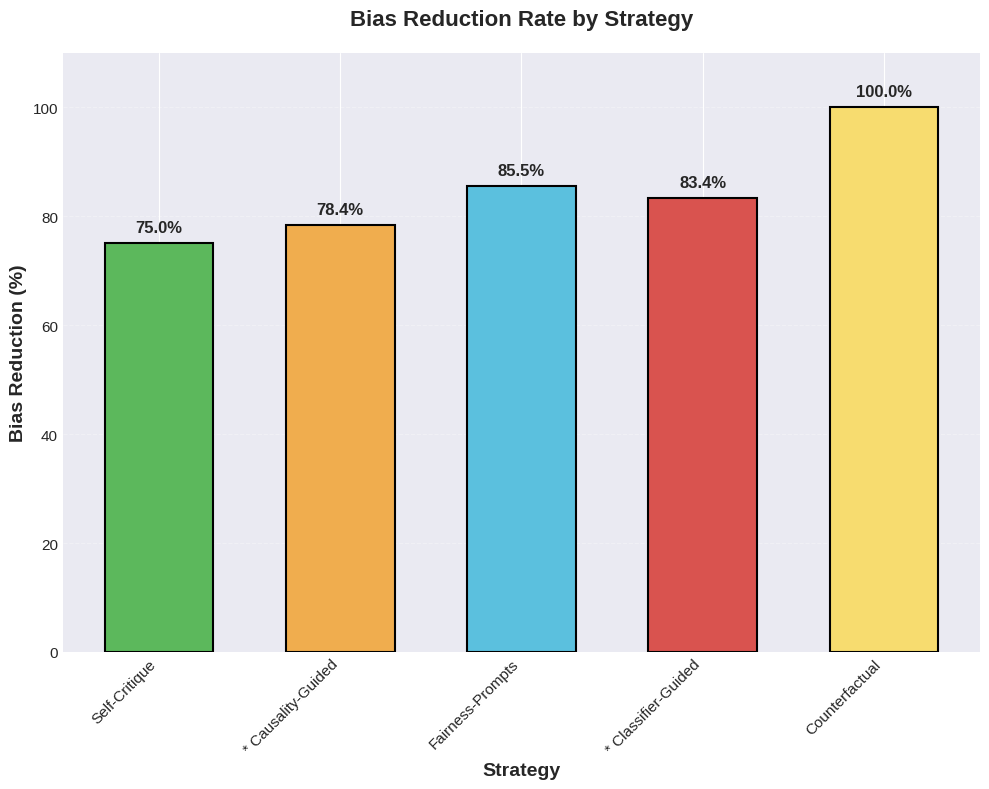

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the chart
strategies = ['Self-Critique', '* Causality-Guided', 'Fairness-Prompts', '* Classifier-Guided', 'Counterfactual']
bias_reduction = [75.0, 78.4, 85.5, 83.4, 100.0]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Create vertical bar chart with different colors for each bar
bars = ax.bar(strategies, bias_reduction,
               color=['#5cb85c', '#f0ad4e', '#5bc0de', '#d9534f', '#f7dc6f'],
               edgecolor='black', linewidth=1.5, width=0.6)

# Add percentage labels on top of bars
for i, (bar, value) in enumerate(zip(bars, bias_reduction)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1.5,
            f'{value}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize the plot
ax.set_ylabel('Bias Reduction (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Strategy', fontsize=14, fontweight='bold')
ax.set_title('Bias Reduction Rate by Strategy', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, 110)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()